In [75]:
#==========================================================================
# Libraries
#==========================================================================

import pickle
import dill
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
from scipy.integrate import solve_ivp
import scipy.io
import pandas as pd
import time
from gekko import GEKKO
from tqdm import tqdm
import copy
import importlib
import sys
import os

#==========================================================================
# Functions
#==========================================================================

main_folder_path = '/Users/mayaharris/Documents/GitHub/pyssem/pyssem'

sys.path.append(main_folder_path) 
import utils.control.control  
importlib.reload(utils.control.control)
from utils.control.control import *

from utils.drag.drag import calculate_orbital_lifetimes

#==========================================================================
# Plotting settings
#==========================================================================
sel_LineWidth = 3
sel_LineWidth2 = 1.5
sel_MarkerWidth = 10
sel_LineWidthAxis = 1
sel_FontSize = 14  
# folder = '/Users/glavezzi/Library/CloudStorage/Box-Box/MIT/PROJETCS/SSEM/Draft/AAS24/figure' 

In [76]:
# # --- Custom SymPy to Gekko Expression Converter ---
# def _sympy_to_gekko_expr_with_intermediates(sympy_expr, symbol_map, gekko_model, complexity_threshold=1000, counter=None):
#     """
#     Recursively converts a SymPy expression to a Gekko expression,
#     inserting m.Intermediate variables for complex sub-expressions to
#     avoid the 'Max Equation Length' error.

#     Args:
#         sympy_expr: The SymPy expression to convert.
#         symbol_map: A dictionary mapping SymPy symbols to Gekko variables.
#         gekko_model: The GEKKO model instance.
#         complexity_threshold: If the string representation of a SymPy sub-expression
#                               exceeds this length, an m.Intermediate is created for it.
#                               This heuristic needs tuning based on your specific equations.
#         counter: A mutable list [int] to generate unique names for intermediate variables.
#                  e.g., ['_gekko_inter_0', '_gekko_inter_1'].

#     Returns:
#         A Gekko variable or expression representing the converted SymPy expression.
#     """
#     if counter is None:
#         counter = [0] # Initialize if not provided

#     # Base cases for numbers and known constants
#     if isinstance(sympy_expr, (sp.Number, int, float)):
#         return float(sympy_expr)
    
#     # --- ADDED THIS CHECK FOR SYMPY.PI AND SYMPY.E ---
#     if sympy_expr == sp.pi:
#         return np.pi # Or math.pi
#     if sympy_expr == sp.E:
#         return np.e # Or math.e
#     # --- END ADDITION ---
    
#     if isinstance(sympy_expr, sp.Symbol):
#         if sympy_expr in symbol_map:
#             return symbol_map[sympy_expr]
#         else:
#             # Assume unmapped symbols are numerical constants (e.g., a specific constant not in symbol_map)
#             try:
#                 return float(sympy_expr)
#             except ValueError:
#                 raise ValueError(f"Unmapped SymPy symbol or constant: {sympy_expr}")

#     # Recursive step - convert arguments first
#     gekko_args = []
#     for arg in sympy_expr.args:
#         converted_arg = _sympy_to_gekko_expr_with_intermediates(arg, symbol_map, gekko_model, complexity_threshold, counter)
#         gekko_args.append(converted_arg)

#     # Now, reconstruct the Gekko expression based on the SymPy operator
#     gekko_op_result = None
#     if isinstance(sympy_expr, sp.Add):
#         # m.sum handles sums of many terms efficiently without creating a single long string
#         gekko_op_result = gekko_model.sum(gekko_args)
#     elif isinstance(sympy_expr, sp.Mul):
#         if not gekko_args:
#             gekko_op_result = 1.0
#         else:
#             current_product = 1.0
#             for arg in gekko_args:
#                 current_product *= arg
#             gekko_op_result = current_product
#     elif isinstance(sympy_expr, sp.Pow):
#         if len(gekko_args) == 2:
#             gekko_op_result = gekko_args[0] ** gekko_args[1]
#         else:
#             raise ValueError(f"Unexpected number of args for SymPy Power: {sympy_expr}")
#     elif isinstance(sympy_expr, sp.Function):
#         # Map common SymPy functions to Gekko functions
#         if sympy_expr.func == sp.exp:
#             gekko_op_result = gekko_model.exp(gekko_args[0])
#         elif sympy_expr.func == sp.sin:
#             gekko_op_result = gekko_model.sin(gekko_args[0])
#         elif sympy_expr.func == sp.cos:
#             gekko_op_result = gekko_model.cos(gekko_args[0])
#         elif sympy_expr.func == sp.log:
#             gekko_op_result = gekko_model.log(gekko_args[0])
#         elif sympy_expr.func == sp.Abs:
#             gekko_op_result = gekko_model.abs(gekko_args[0])
#         # Add more SymPy function to Gekko function mappings as needed
#         else:
#             raise NotImplementedError(f"SymPy function {sympy_expr.func} not yet implemented for Gekko conversion: {sympy_expr}")
#     else:
#         # This fallback might catch other unhandled SymPy types.
#         # It's good to keep this for debugging if new types emerge.
#         raise NotImplementedError(f"Unsupported SymPy expression type: {type(sympy_expr)} - {sympy_expr}")

#     # After constructing the Gekko equivalent for this SymPy node's operation,
#     # check if the *original SymPy sub-expression* was complex enough.
#     # If so, wrap it in an m.Intermediate to break the equation length.
#     if len(str(sympy_expr)) > complexity_threshold:
#         inter_name = f'_gekko_inter_{counter[0]}'
#         counter[0] += 1
#         intermediate_var = gekko_model.Intermediate(gekko_op_result, name=inter_name)
#         return intermediate_var
#     else:
#         return gekko_op_result
    
# # --------------------------------------------------------------------------
# # HELPER FUNCTION: round_sympy_constants
# # This function rounds numerical constants within a SymPy expression tree.
# # --------------------------------------------------------------------------
# def round_sympy_constants(expr, sig_figs=5):
#     """
#     Recursively rounds all sympy.Float constants, sympy.pi, and sympy.E
#     within an expression to a specified number of significant figures.
#     """
#     replacements = {}
    
#     # 1. Handle regular sympy.Float numbers
#     for atom in expr.atoms(sp.Float):
#         rounded_float = sp.Float(f"{float(atom):.{sig_figs}g}")
#         replacements[atom] = rounded_float
        
#     # 2. Handle sympy.pi
#     # Check if sp.pi is an atom in the expression
#     if sp.pi in expr.atoms(): # Using .atoms() without argument gets all atoms, including special constants
#         rounded_pi = sp.Float(f"{float(sp.pi):.{sig_figs}g}")
#         replacements[sp.pi] = rounded_pi
        
#     # 3. Handle sympy.E (Euler's number) for completeness
#     if sp.E in expr.atoms():
#         rounded_e = sp.Float(f"{float(sp.E):.{sig_figs}g}")
#         replacements[sp.E] = rounded_e
        
#     # Use expr.xreplace() to apply all replacements simultaneously
#     return expr.xreplace(replacements)

In [77]:
# --------------------------------------------------------------------------
# HELPER FUNCTION: round_sympy_constants (This function is fine)
# --------------------------------------------------------------------------
def round_sympy_constants(expr, sig_figs=5):
    """
    Recursively rounds all sympy.Float constants, sympy.pi, and sympy.E
    within an expression to a specified number of significant figures.
    """
    replacements = {}
    for atom in expr.atoms(sp.Float):
        rounded_float = sp.Float(f"{float(atom):.{sig_figs}g}")
        replacements[atom] = rounded_float
    if sp.pi in expr.atoms():
        rounded_pi = sp.Float(f"{float(sp.pi):.{sig_figs}g}")
        replacements[sp.pi] = rounded_pi
    if sp.E in expr.atoms():
        rounded_e = sp.Float(f"{float(sp.E):.{sig_figs}g}")
        replacements[sp.E] = rounded_e
    return expr.xreplace(replacements)

# --------------------------------------------------------------------------
# CORRECTED HELPER FUNCTION: _sympy_to_gekko_expr_with_intermediates
# The complexity check is now on the *Gekko expression string length*.
# --------------------------------------------------------------------------
def _sympy_to_gekko_expr_with_intermediates(sympy_expr, symbol_map, gekko_model, 
                                            apply_intermediates, 
                                            complexity_threshold=1000, counter=None): # complexity_threshold is now very important again
    """
    Recursively converts a SymPy expression to a Gekko expression.
    Inserts m.Intermediate variables for complex sub-expressions only if `apply_intermediates` is True,
    and the *Gekko expression's string length* exceeds `complexity_threshold`.
    """
    if counter is None:
        counter = [0] 

    # Base cases
    if isinstance(sympy_expr, (sp.Number, int, float)):
        return float(sympy_expr)
    
    if sympy_expr == sp.pi:
        return np.pi
    if sympy_expr == sp.E:
        return np.e
    
    if isinstance(sympy_expr, sp.Symbol):
        if sympy_expr in symbol_map:
            return symbol_map[sympy_expr]
        else:
            try:
                return float(sympy_expr)
            except ValueError:
                raise ValueError(f"Unmapped SymPy symbol or constant: {sympy_expr}")

    # Recursive step - convert arguments first
    # gekko_args now contain Gekko variables or m.Intermediate objects.
    gekko_args = []
    for arg in sympy_expr.args:
        converted_arg = _sympy_to_gekko_expr_with_intermediates(arg, symbol_map, gekko_model, 
                                                                apply_intermediates, 
                                                                complexity_threshold, counter)
        gekko_args.append(converted_arg)

    # Reconstruct the Gekko expression for the current SymPy operation
    # This `current_gekko_expression` is the direct Gekko translation of the current sympy_expr.
    current_gekko_expression = None
    if isinstance(sympy_expr, sp.Add):
        current_gekko_expression = gekko_model.sum(gekko_args)
    elif isinstance(sympy_expr, sp.Mul):
        if not gekko_args: current_gekko_expression = 1.0
        else:
            current_product = 1.0
            for arg in gekko_args: current_product *= arg
            current_gekko_expression = current_product
    elif isinstance(sympy_expr, sp.Pow):
        if len(gekko_args) == 2: current_gekko_expression = gekko_args[0] ** gekko_args[1]
        else: raise ValueError(f"Unexpected number of args for SymPy Power: {sympy_expr}")
    elif isinstance(sympy_expr, sp.Function):
        if sympy_expr.func == sp.exp: current_gekko_expression = gekko_model.exp(gekko_args[0])
        elif sympy_expr.func == sp.sin: current_gekko_expression = gekko_model.sin(gekko_args[0])
        elif sympy_expr.func == sp.cos: current_gekko_expression = gekko_model.cos(gekko_args[0])
        elif sympy_expr.func == sp.log: current_gekko_expression = gekko_model.log(gekko_args[0])
        elif sympy_expr.func == sp.Abs: current_gekko_expression = gekko_model.abs(gekko_args[0])
        else: raise NotImplementedError(f"SymPy function {sympy_expr.func} not yet implemented for Gekko conversion: {sympy_expr}")
    else:
        raise NotImplementedError(f"Unsupported SymPy expression type: {type(sympy_expr)} - {sympy_expr}")

    # --- THE CRITICAL FIX IS HERE ---
    # Now, the complexity check is on the *string length of the Gekko expression* itself.
    # This is the actual length Gekko will see when writing to the APM file.
    if apply_intermediates and len(str(current_gekko_expression)) > complexity_threshold:
        inter_name = f'_gekko_inter_{counter[0]}'
        counter[0] += 1
        intermediate_var = gekko_model.Intermediate(current_gekko_expression, name=inter_name)
        return intermediate_var
    else:
        # If not complex enough (in Gekko terms), return the direct Gekko expression.
        # This will be used by the parent recursive call.
        return current_gekko_expression

In [78]:
#==========================================================================
# Model from .json file
#==========================================================================

# filename = 'scenario-properties-test-no-run.pkl'
# filename = 'scenario-properties-test-no-run-mult.pkl'
# filename = 'scenario-properties-baseline-no-run_24_shells.pkl' # 15 species - 24 shells
# filename = 'scenario-properties-baseline-no-run_14_shells.pkl' # 15 species - 14 shells
# filename = 'scenario-properties-baseline-no-run_5_shells.pkl' # 15 species - 5 shells
# filename = 'scenario-properties-test-no-run-policy.pkl' # 3 species - modified policy
# filename = 'test_to_delete.pkl' # 3 species - modified policy
# filename = 'test_3_species_sym_spread.pkl' # 3 species - modified policy
# filename = 'test_maya.pkl' 
# filename = 'test_maya_spreading.pkl' 
# filename = 'sep_cluster.pkl'
# filename = 'test_mc_for_indigo.pkl'
# filename = 'test_spreading.pkl'
# filename = 'test_no_spreading.pkl'
filename = 'sep_partial_species_yes_spreading.pkl'

with open(os.path.join(main_folder_path[:-7], filename), 'rb') as f:
    baseline = pickle.load(f)
# baseline.equations
calculate_orbital_lifetimes(baseline)

# Find the difference (symbols in equations but not in all_symbolic_vars) after 
# converting the list to a set for efficient difference calculation
difference_vars = baseline.equations.free_symbols - set(baseline.all_symbolic_vars)
ordered_difference_vars = sorted(list(difference_vars), key=lambda x: sort_key(str(x), baseline.species_names))

vars_dict = create_vars_dict(ordered_difference_vars)
print("-----------------------------------------")
# for name, var_list in vars_dict.items():
    # print(f"{name}: {var_list}")
print("Comment out lines above to see all variables in the dictionary")

equations_flattened = [baseline.equations[i, j] for j in range(baseline.equations.cols) for i in range(baseline.equations.rows)]

Pm_s, deltat_s, lam_s, u_var_s = extract_vars(vars_dict)
var_s = baseline.all_symbolic_vars
# # --------------------------------------------------------------------------
# # NEW CODE TO INSERT: Map generic 'xN' symbols in equations to actual 'var_s' symbols
# # --------------------------------------------------------------------------
# print("Mapping generic 'xN' symbols in equations_flattened to specific 'var_s' symbols...")
# symbol_mapping_for_equations = {}
# for i, sym_var in enumerate(var_s):
#     # Create a SymPy symbol for 'xI' where I is the index, if it doesn't already exist.
#     # We assume 'x0', 'x1', ... are the generic placeholders for states.
#     generic_x_symbol = sp.Symbol(f'x{i}')
#     symbol_mapping_for_equations[generic_x_symbol] = sym_var

# transformed_equations_flattened = []
# for eq in equations_flattened:
#     # Use xreplace to replace all instances of generic 'xI' symbols with actual var_s symbols
#     transformed_eq = eq.xreplace(symbol_mapping_for_equations)
#     transformed_equations_flattened.append(transformed_eq)

# equations_flattened = transformed_equations_flattened
# print(f"Generic 'xN' symbols replaced with {len(var_s)} specific state variable symbols from 'var_s'.")
# # --------------------------------------------------------------------------

# # --------------------------------------------------------------------------
# # Apply numerical precision reduction to constants
# # --------------------------------------------------------------------------
# print("Applying numerical constant rounding to expressions in equations_flattened...")
# # IMPORTANT: Adjust 'num_significant_figures' based on your model's accuracy requirements.
# # Start with a moderate value (e.g., 5-7), and go lower if needed, or higher if accuracy suffers.
# num_significant_figures = 2

# rounded_equations_flattened = []
# for eq in equations_flattened:
#     rounded_equations_flattened.append(round_sympy_constants(eq, sig_figs=num_significant_figures))

# # # Replace the original list with the new, rounded one
# equations_flattened = rounded_equations_flattened 
# print(f"Numerical constants in equations_flattened rounded to {num_significant_figures} significant figures.")
# # --------------------------------------------------------------------------

# --------------------------------------------------------------------------
# NEW CODE TO INSERT: Apply numerical precision reduction (and no xN mapping needed)
# --------------------------------------------------------------------------
print("Applying numerical constant rounding to expressions in equations_flattened...")
num_significant_figures = 2 # Start with 5, reduce to 3 or 2 if needed for `Max Equation Length` error
rounded_equations_flattened = []
for eq in equations_flattened:
    rounded_equations_flattened.append(round_sympy_constants(eq, sig_figs=num_significant_figures))
equations_flattened = rounded_equations_flattened 
print(f"Numerical constants in equations_flattened rounded to {num_significant_figures} significant figures.")
# --------------------------------------------------------------------------


# --------------------------------------------------------------------------
# NEW CODE TO INSERT: Define `func` for `solve_ivp` (before Gekko model definition)
# --------------------------------------------------------------------------
# Create a single, flat list of all input symbols for lambdify
dist_syms_flat = np.concatenate((lam_s, Pm_s, deltat_s)).tolist()
all_input_symbols_for_func = list(var_s) + list(u_var_s) + dist_syms_flat

# Define `func` using `sp.lambdify`. This `func` is for `solve_ivp` external simulation.
func = sp.lambdify(all_input_symbols_for_func, equations_flattened, 'numpy')
# --------------------------------------------------------------------------


# Parameters
N_shell = baseline.n_shells
R02 = baseline.R0_km

# Policy parameters
# for species_name, species_list in baseline.species_cells.items():
#     for species_properties in species_list:
#         print(species_properties.country, species_properties.mission_type, species_properties.mission_objective)

#==========================================================================
# Define symbolic variables based on loaded scenario
#==========================================================================
# Pm_s, deltat_s, lam_s, u_var_s = extract_vars(vars_dict)
# var_s = baseline.all_symbolic_vars

category_indices = {}
current_index = 0
for category, objects_list in baseline.species.items():
    num_objects = len(objects_list)
    # Create the list of indices for the current category
    indices = list(range(current_index, current_index + num_objects))
    category_indices[category] = indices
    # Update the starting index for the next category
    current_index += num_objects
# Now you can get the specific indices you need
active_indices = category_indices.get('active')
debris_indices = category_indices.get('debris')
rocket_body_indices = category_indices.get('rocket_body')
maneuverable_indices = []
for i1 in range(len(category_indices.get('active'))):
    if baseline.species['active'][category_indices.get('active')[i1]].maneuverable:
        maneuverable_indices.append(category_indices.get('active')[i1])
print("-----------------------------------------")
print(f"All calculated indices: {category_indices}")
print(f"Indices for 'active': {active_indices}")
print(f"Indices for 'rocket_body': {rocket_body_indices}")
print(f"Indices for 'maneuverable': {maneuverable_indices}")
# ORIGINAL
# active_species_indices = int(len(lam_s)/N_shell)
# active_species_per_shells = len(lam_s)
print("-----------------------------------------")
print(f"{baseline.species_length} species: {', '.join(baseline.species_names)}")
print(f"Number of shells: {baseline.n_shells}")
print(f"Number of active species: {len(active_indices)}")
print(f"Number of debris species: {len(debris_indices)}")
print(f"Number of rocket bodies: {len(rocket_body_indices)}")
print(f"Number of launch variables (active species + rocket bodies) per shell: {(len(active_indices) + len(rocket_body_indices)) * N_shell}")
print("-----------------------------------------")
adr_species = len(debris_indices) + len(rocket_body_indices)
check_control_launch_sym = any(s.name.startswith('u_l_') for s in u_var_s)

#==========================================================================
# Define propagation function
#==========================================================================
# func = sp.lambdify((var_s, u_var_s, np.concatenate((lam_s, Pm_s, deltat_s)).tolist()), equations_flattened, 'numpy')
# def ode_func(t, x, func, u_var, mdd):
#     return np.array(func(x, u_var, mdd)).flatten()


# all_input_symbols = list(var_s) + list(u_var_s) + np.concatenate((lam_s, Pm_s, deltat_s)).tolist()
# func = sp.lambdify(all_input_symbols, equations_flattened, 'numpy')
# def ode_func(t, x_current_values, func_passed, u_control_values, d_disturbance_values):
#     """
#     Wrapper function for scipy.integrate.solve_ivp.
#     It prepares the input for the lambdify-generated 'func_passed' by concatenating
#     state, control, and disturbance values in the expected order, then unpacks them.

#     Args:
#         t (float): Current time. (Not used by 'func_passed' directly, but required by solve_ivp signature)
#         x_current_values (np.array): Current values of state variables (x).
#         func_passed (callable): The lambdify-generated function.
#         u_control_values (np.array): Current values of control variables (u).
#         d_disturbance_values (np.array): Current values of disturbance variables (d).

#     Returns:
#         np.array: Derivatives of state variables (dxdt).
#     """
#     # Create the single, flat list of all numerical values, matching the lambdify order.
#     # Order: [states_from_var_s, controls_from_u_var_s, disturbances_from_dist_syms_flat]
#     all_current_input_values = list(x_current_values) + list(u_control_values) + list(d_disturbance_values)
    
#     # --- CRITICAL FIX: Unpack the list when calling func_passed ---
#     derivatives = func_passed(*all_current_input_values) # <--- ADD THE ASTERISK HERE
    
#     return np.array(derivatives).flatten()

def ode_func(t, x_current_values, func_passed, u_control_values, d_disturbance_values):
    """
    Wrapper function for scipy.integrate.solve_ivp.
    It prepares the input for the lambdify-generated 'func_passed' by concatenating
    state, control, and disturbance values in the expected order, then unpacks them.
    """
    all_current_input_values = list(x_current_values) + list(u_control_values) + list(d_disturbance_values)
    
    # CRITICAL: Unpack the list when calling func_passed
    derivatives = func_passed(*all_current_input_values)
    
    return np.array(derivatives).flatten()

-----------------------------------------
Comment out lines above to see all variables in the dictionary
Applying numerical constant rounding to expressions in equations_flattened...
Numerical constants in equations_flattened rounded to 2 significant figures.
-----------------------------------------
All calculated indices: {'active': [0, 1, 2, 3], 'debris': [4, 5, 6, 7, 8, 9], 'rocket_body': [10]}
Indices for 'active': [0, 1, 2, 3]
Indices for 'rocket_body': [10]
Indices for 'maneuverable': [0, 1, 2, 3]
-----------------------------------------
11 species: S_143kg, S_321kg, S_777kg, Su, N_0.032kg, N_1.88kg, N_143kg, N_321kg, N_777kg, N_1820kg, B
Number of shells: 12
Number of active species: 4
Number of debris species: 6
Number of rocket bodies: 1
Number of launch variables (active species + rocket bodies) per shell: 60
-----------------------------------------


In [79]:
#==========================================================================
# Selection and initialization of parameters for the simulation
#==========================================================================
np.random.seed(25) # Seed for reproducibility

# 1: IC from predefined array 
# 2: IC from MC2SSEM_population  
# 3: random or user selected for n species
# 4: for SEPs (might work w/ AMOS-23 scenario using .csv file from ADEPT too)
sel_ic = 4

# Custom launches
sel_custom_launches = 0 # 1: yes ; 0: no

# 1: PD ; 2: NMPC
sel_controller = 2

# NMPC cost function selection
sel_nmpc_cost_function = 1 # 0: standard quadratic ; 1: CSI ; 2: UMPY 

# PMD rate control: 0: no ; 1: yes 
sel_pmd_control = 0 # (ONLY with PD controller for NOW)

# Risk index 
sel_risk_index = 3 # 0: no risk index ; 1: CSI ; 2: UMPY ; 3: CSI and UMPY

# 1: yes ; 0: no  
sel_launch_rate_plot =  0 # Launch rate plot
sel_pmd_plot =          1 # PMD plot
sel_deltat_plot =       0 # Orbital lifetime plot
sel_cumulative_plot =   1 # Cumulative plot

# Propagation time
tf_ss = 100.0
dur = tf_ss
Ts = 1.0
# Ts = 0.1
tspan = np.arange(0, dur+Ts, Ts)

# ODE tolerances
rtol = 1e-2
atol = 1e-2

if sel_controller == 1:
    print('PD controller selected')
elif sel_controller == 2:
    print('NMPC controller selected')    
    if sel_nmpc_cost_function == 0:
        print('NMPC cost function: standard quadratic')
    elif sel_nmpc_cost_function == 1:
        print('NMPC cost function: CSI')
    elif sel_nmpc_cost_function == 2:
        print('NMPC cost function: UMPY')
    
if sel_pmd_control == 1:
    print('PMD controller selected')
    
#==========================================================================
# Species mean and std for initial population of each species (for sel_ic = 3)
# 1. User-selected: as many as the number of species
# 2. Random: uses the mean and std to assign them automatically to each species; 
#    e.g. first species is assigned the first mean and std, second species the 
#    second mean and std, etc.
#==========================================================================

# User selected
Species_mean = np.array([100, 200, 50])
Species_std = np.array([25, 40, 10])

# Random:
Species_mean, Species_std = assign_stats_to_species(baseline.species_names, Species_mean, Species_std)

#==========================================================================
# Controller reference values 
# 1. User-selected: as many as the number of species
# 2. Random: uses the ref_mult and ref_dot_mult to assign them automatically 
#    to each species; e.g. first species is assigned the first values, second 
#    species the second values, etc.
#==========================================================================
# Reference values for states
ref_mult = np.array([0, 1, 1]) * 1

# Reference values for rate of change of states
ref_dot_mult = np.array([0.5, 0, -0.8]) * 0

# Random:
ref_mult, ref_dot_mult = assign_stats_to_species(baseline.species_names, ref_mult, ref_dot_mult)

#==========================================================================
# PD Controller gains - Launch rate and ADR 
# 1. User-selected: as many as the number of species
# 2. Random: uses the K_p and K_d to assign them automatically to each species; 
#    e.g. first species is assigned the first values, second species the second values, etc.
#==========================================================================
K_p = np.array([1 * 0,
                1 * 1,
                1 * 1]) * 0

K_d = np.array([1 * 0,
                1 * 1,
                1 * 1]) * 0

# Random:
K_p, K_d = assign_stats_to_species(baseline.species_names, K_p, K_d)

#==========================================================================
# Control Settings - NMPC
#==========================================================================
# MPC - Prediction horizon steps
Tp = 5

# MPC - Control horizon steps
Tc = 3 # Positive integer, m, between 1 and p, inclusive, 
# where p is equal to PredictionHorizon. In this case, the controller computes 
# m free control moves occurring at times k through k+m-1, and holds the controller 
# output constant for the remaining prediction horizon steps from k+m through k+p-1. 
# Here, k is the current control interval.
# The product of Tp and Ts is the prediction time; that is,
# how far the controller looks into the future.

#==========================================================================
# Active Debris Removal (ADR) - Saturation Functions 
# ==========================================================================
# Note:
# - A value of zero is automatically assigned for active satellites (S) species.
# - Choose the values of saturation to assignt to the remaining species.
# - If only one saturation value,same value is assigned to all species.
#==========================================================================

# Time-dependent
adr_initial = 0
time_increment_in_years = 25
adr_increment_per_species = 5 * adr_species
satur1 = lambda t: -(adr_initial + np.floor(t / time_increment_in_years) * adr_increment_per_species) / adr_species 
# satur2 = lambda t: -(adr_initial + np.floor(t / time_increment_in_years) * adr_increment_per_species) / adr_species

# Constant
# satur1 = lambda t: - 10 + 0 * t
# satur2 = lambda t: - 20 + 0 * t

satur = assign_saturations(baseline.species_names, [satur1]) 

#==========================================================================
# Initial conditions 
# (TO BE UPDATED w/ new initial pop and launch traffic)
#==========================================================================

print("-----------------------------------------")
print('Initial population')

if sel_ic == 1:
    # Mean and standard deviation values
    S_mean = 142
    S_std = 497
    D_mean = 73
    D_std = 79
    N_mean = 280
    N_std = 354

    # Generate random values and create initial conditions
    S_rand = randn2(N_shell)
    x0_S = np.abs(np.round(S_mean + S_std * S_rand)).astype(int)
    D_rand = randn2(N_shell)
    x0_D = np.abs(np.round(D_mean + D_std * D_rand)).astype(int)
    N_rand = randn2(N_shell)
    x0_N = np.abs(np.round(N_mean + N_std * N_rand)).astype(int)

    # Combine initial conditions
    x0 = np.concatenate((x0_S, x0_N, x0_D))
    spec_names = ["Su", "N", "D"]

    # Create pandas DataFrame (equivalent to MATLAB's table)
    df = pd.DataFrame(x0.reshape((3,N_shell)).T, columns=spec_names)
    # print(df.to_string(index=False)) # Print DataFrame without index

    # Print table with shell numbers (optional)
    df_with_shell = pd.DataFrame(np.column_stack((np.arange(1, N_shell+1),x0.reshape((3,N_shell)).T)), 
                                   columns=['Shell'] + spec_names)
    print(df_with_shell.to_string(index=False)) # Print DataFrame without index

elif sel_ic == 2:
    # change order of Su with S
    baseline.species_types = [
        'Su' in baseline.species_cells and baseline.species_cells['Su'],
        'D' in baseline.species_cells and baseline.species_cells['D'],
        'N' in baseline.species_cells and baseline.species_cells['N'],
        'S' in baseline.species_cells and baseline.species_cells['S'],
        'B' in baseline.species_cells and baseline.species_cells['B'],
        'U' in baseline.species_cells and baseline.species_cells['U']
    ]
    mass_lb = 0.00141372; # lower bound of mass class for object binning (inclusive), 1 cm diameter Al sphere
    mass_ub = 100000; # upper bound of mass class for object binning (exclusive, except for top mass bin, which is inclusive)
    for species_name, species_list in baseline.species_cells.items():
        for species_properties in species_list:
            species_properties.mass_lb = mass_lb
            species_properties.mass_ub = mass_ub
    init_mat = scipy.io.loadmat('initialized.mat')
    sats = init_mat['sats']
    x0 = MC2SSEM_population(sats, baseline)
    spec_names = ["Su", "N", "D"]

    # Create pandas DataFrame (equivalent to MATLAB's table)
    df = pd.DataFrame(x0.reshape((3,N_shell)).T, columns=spec_names)
    # print(df.to_string(index=False)) # Print DataFrame without index
    x0_S = df['Su'].values
    x0_D = df['D'].values
    x0_N = df['N'].values

    # Print table with shell numbers (optional)
    df_with_shell = pd.DataFrame(np.column_stack((np.arange(1, N_shell+1),x0.reshape((3,N_shell)).T)), 
                                   columns=['Shell'] + spec_names)
    print(df_with_shell.to_string(index=False)) # Print DataFrame without index

elif sel_ic == 3:
    x0 = []
    for i1 in range(baseline.species_length):
        # Generate random values and create initial conditions
        Species_rand = randn2(N_shell)
        # Combine initial conditions
        x0 = np.concatenate((x0, np.abs(np.round(Species_mean[i1] + Species_std[i1] * Species_rand))))

    x0 = x0.astype(int)
    # Create pandas DataFrame (equivalent to MATLAB's table)
    df = pd.DataFrame(x0.reshape((baseline.species_length,N_shell)).T, columns=baseline.species_names)
    # print(df.to_string(index=False)) # Print DataFrame without index

    # Print table with shell numbers (optional)
    df_with_shell = pd.DataFrame(np.column_stack((np.arange(1, N_shell+1),x0.reshape((baseline.species_length,N_shell)).T)), 
                                    columns=['Shell'] + baseline.species_names)
    print(df_with_shell.to_string(index=False)) # Print DataFrame without index

elif sel_ic == 4:
    # Initial population baseline.x0 as pd.DataFrame: 
    x0 = baseline.x0.T.values.flatten()

    # Print table with shell numbers (optional)
    df_with_shell = pd.DataFrame(np.column_stack((np.arange(1, N_shell+1),x0.reshape((baseline.species_length,N_shell)).T)), 
                                    columns=['Shell'] + baseline.species_names)
    print(df_with_shell.to_string(index=False)) # Print DataFrame without index

    # # Future launch model baseline.FLM_steps as a pd.DataFrame OR 
    # # If baseline.baseline == False, the baseline.FLM_steps are 
    # # converted into lambda functions for each species, 
    # # by using baseline.future_launch_model(baseline.FLM_steps):
    # # NOTE: .fillna(0) is used to replace NaN values with 0
    # non_debris_species = {key: value for key, value in baseline.species.items() if key != 'debris'}
    # x0_lam_no_noise = []
    # for species_name, species_list in non_debris_species.items():
    #     for species_properties in species_list:
    #         x0_lam_no_noise.append( np.array(baseline.FLM_steps[species_properties.sym_name].fillna(0)).reshape(baseline.n_shells, baseline.steps) )
    # x0_lam_no_noise = np.concatenate(x0_lam_no_noise, axis=0)
    # x0_lam = x0_lam_no_noise

    # --- Corrected Launch Rate Retrieval ---
    # Let's assume baseline.FLM_steps is the DataFrame created by SEP_traffic_model
    # It has columns: 'epoch_start_date', 'alt_bin', and one for each species.
    # Initialize the list to hold the final (shells x time) arrays for each species
    x0_lam_list = []
    non_debris_species = {key: value for key, value in baseline.species.items() if key != 'debris'}
    # We need the time step duration to convert counts back to rates
    time_step_duration = baseline.simulation_duration / baseline.steps
    for species_name, species_list in non_debris_species.items():
        for species_properties in species_list:
            sym_name = species_properties.sym_name
            # 1. Select the relevant data for the current species
            if sym_name not in baseline.FLM_steps.columns:
                # If this species has no launches, create a zero array and continue
                zero_launches = np.zeros((baseline.n_shells, baseline.steps))
                x0_lam_list.append(zero_launches)
                continue
            species_df = baseline.FLM_steps[['epoch_start_date', 'alt_bin', sym_name]]
            # 2. Pivot the DataFrame to get the correct (alt_bin, epoch_start_date) structure
            pivoted_df = species_df.pivot(
                index='alt_bin', 
                columns='epoch_start_date', 
                values=sym_name)
            # --- START OF THE FIX ---
            # After pivoting, the DataFrame might contain NaNs for combinations
            # that didn't exist in the long-format data.
            # We must replace these NaNs with 0.
            pivoted_df.fillna(0, inplace=True)
            # --- END OF THE FIX ---
            # 3. Convert the launch COUNTS to launch RATES
            launch_rate_matrix = pivoted_df.values / time_step_duration
            # 4. Append the correctly structured (n_shells, steps) matrix
            x0_lam_list.append(launch_rate_matrix)
    # 5. Concatenate all the species matrices into one large array
    x0_lam_no_noise = np.concatenate(x0_lam_list, axis=0)
    x0_lam = x0_lam_no_noise

# for species_name, species_list in baseline.species_cells.items():
#     print(species_name)
#     for species_properties in species_list:
#         print(len(species_properties.lambda_funs))

#==========================================================================
# Reference values
#==========================================================================

if sel_ic == 3 or sel_ic == 4:
    ref = []
    ref_dot = []
    for i1 in range(baseline.species_length):
        start_idx = i1 * baseline.n_shells
        end_idx = start_idx + baseline.n_shells
        ref = np.concatenate((ref, x0[start_idx:end_idx] * ref_mult[i1]))
        ref_dot = np.concatenate((ref_dot, np.ones(baseline.n_shells) * ref_dot_mult[i1]))
else:
    ref_S = x0_S * ref_mult[0] * 1
    ref_D = x0_D * ref_mult[1] * 1
    ref_N = x0_N * ref_mult[2] * 1
    ref_S_dot = np.ones(N_shell) * ref_dot_mult[0] * 0
    ref_D_dot = np.ones(N_shell) * ref_dot_mult[1] * 0
    ref_N_dot = np.ones(N_shell) * ref_dot_mult[2] * 0

    ref = np.concatenate([ref_S, ref_N, ref_D])
    ref_dot = np.concatenate([ref_S_dot, ref_N_dot, ref_D_dot])


NMPC controller selected
NMPC cost function: CSI
PMD controller selected
-----------------------------------------
Initial population
 Shell  S_143kg  S_321kg  S_777kg  Su  N_0.032kg  N_1.88kg  N_143kg  N_321kg  N_777kg  N_1820kg   B
     1        0        4       35   3         13         1        0        1        0         0   1
     2        0       74      144  13         89         2        1        0        0         1  17
     3        0       54     1052 488        300         2        0        3        0         0  50
     4        2     4523      873 588       1102        22        1        5        1         0  94
     5        3       53        7 260       3701        40        0        1        0         0 109
     6       36        0       73 100       8441       145        1        0        0         0 134
     7        2        0        0  74      11685       140        0        0        0         0 116
     8        0        0        0  56       8521        63        

In [80]:
# x0 = [0,
#            7,
#           38,
#           44,
#          173,
#          456,
#         2977,
#          379,
#          157,
#           79,
#           59,
#          144,
#           43,
#           17,
#           15,
#           10,
#            1,
#           43,
#            3,
#          101,
#          277,
#            0,
#            2,
#            0,
#           23,
#           15,
#           32,
#           91,
#          186,
#          227,
#          194,
#          309,
#          340,
#          519,
#          829,
#         1224,
#         1381,
#         1160,
#          695,
#          488,
#          353,
#          256,
#          207,
#          145,
#          104,
#          244,
#           86,
#            0,
#            8,
#            3,
#           10,
#           31,
#          114,
#           91,
#          117,
#           98,
#          129,
#          120,
#          150,
#          215,
#          144,
#           80,
#          116,
#          288,
#           56,
#           73,
#           35,
#           39,
#           11,
#            9,
#           18,
#            0]
# x0 = np.array(x0)
# x0 = x0.astype(int)
# baseline.x0 = x0.reshape(baseline.species_length, N_shell)
# # Create pandas DataFrame (equivalent to MATLAB's table)
# df = pd.DataFrame(x0.reshape((baseline.species_length,N_shell)).T, columns=baseline.species_names)
# # print(df.to_string(index=False)) # Print DataFrame without index

# # Print table with shell numbers (optional)
# df_with_shell = pd.DataFrame(np.column_stack((np.arange(1, N_shell+1),x0.reshape((baseline.species_length,N_shell)).T)), 
#                                 columns=['Shell'] + baseline.species_names)
# print(df_with_shell.to_string(index=False)) # Print DataFrame without index

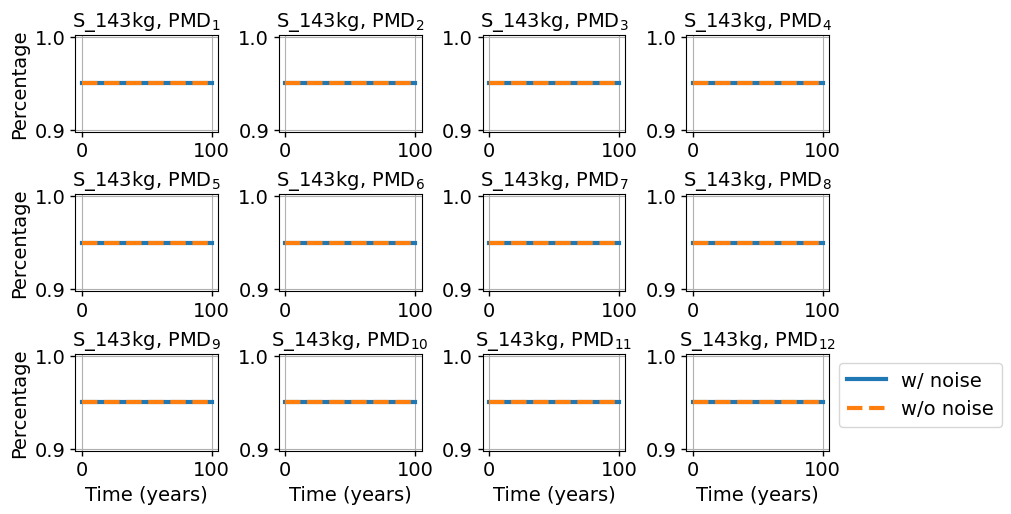

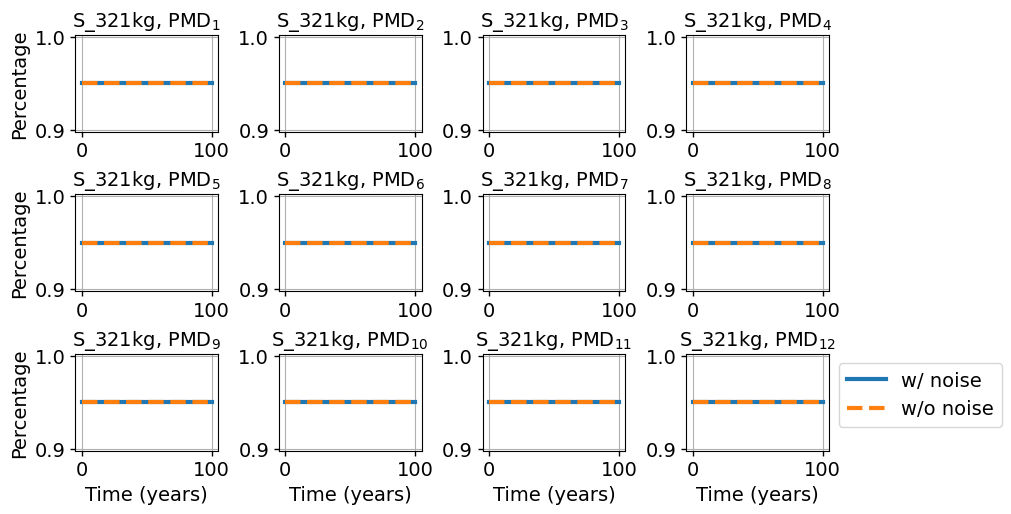

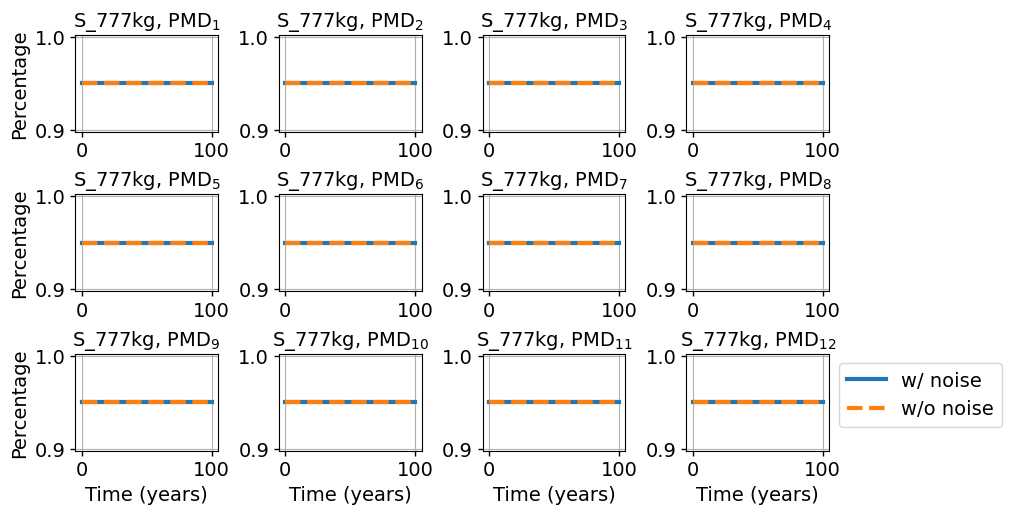

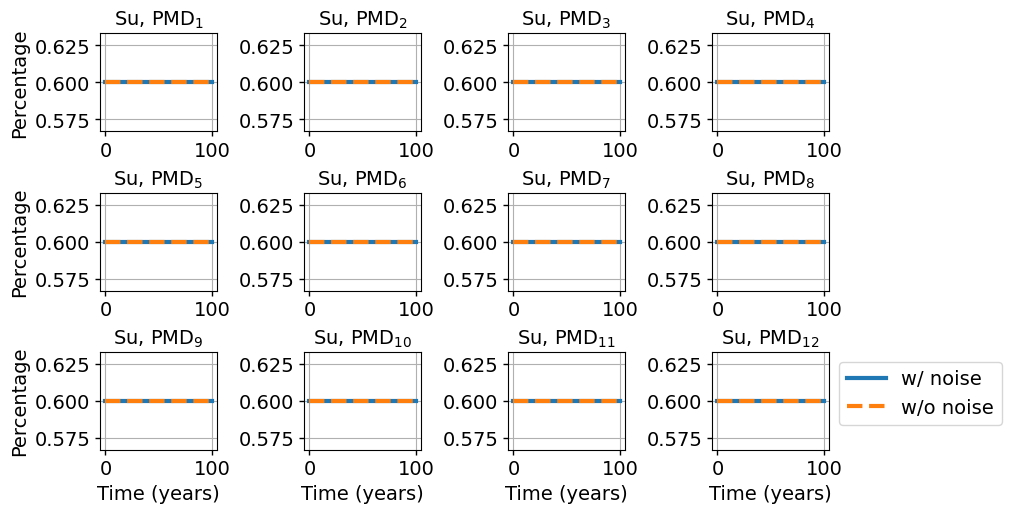

In [ ]:
#==========================================================================
# Launch rate - selection:
# 1. Null 
#       lam_f1(t)
# 2. Time and shell constant based on constant multiplier of the initial population
#       lam_f2(t, const, ref, active_species_indices, N_shell)
# 3. Time and shell varying based on random multiplier of the initial population 
#       lam_f3(t, ref, active_species_per_shells)
# 4. Time and shell varying based on mean and std 
#       lam_f4(t, active_species_per_shells)
# 5. Time and shell based on cosinusoidal function 
#       lam_f5(t, ref, active_species_per_shells)
#==========================================================================

if sel_custom_launches == 1:
    active_species_per_shells = (len(active_indices) + len(rocket_body_indices)) * N_shell
    active_species_indices = active_indices + rocket_body_indices

    # Initialize arrays (# species in i-th shells x # time steps)
    x0_lam_no_noise = np.zeros((active_species_per_shells, len(tspan)))
    x0_lam = np.zeros((active_species_per_shells, len(tspan)))

    const = np.concatenate([0.2*np.ones(len(active_indices)), 0*np.ones(len(debris_indices)), 0.1*np.ones(len(rocket_body_indices))])

    # Evaluate lambda functions for each time step
    for i1 in range(len(tspan)):
        x0_lam_no_noise[:, i1] = lam_f1(tspan[i1])
        # x0_lam_no_noise[:, i1] = lam_f2(tspan[i1], const, ref, active_species_indices, N_shell)
        # x0_lam[:, i1] = lam_f1(tspan[i1]) 
    x0_lam = x0_lam_no_noise

# Plot
if sel_launch_rate_plot == 1:
    active_species_indices = active_indices + rocket_body_indices
    launch_rate_plot(baseline, active_species_indices, x0_lam, x0_lam_no_noise, sel_LineWidth, sel_LineWidthAxis, sel_FontSize)

# # Check output
# i1 = 3
# print(x0_lam_no_noise[i1])
# print(sum(x0_lam_no_noise[:,i1]))

#==========================================================================
# PMD - selection:
# 1. Time and shell constant 
#       pmd_f1(t,const, active_species_indices, N_shell)
# 2. Increasing over time, constant for each shell
#       pmd_f2(t,lower_bound,upper_bound, active_species_indices, N_shell, tspan)
# 3. Increasing over time with randomness, constant for each shell
#       pmd_f3(t,lower_bound,upper_bound, active_species_indices, N_shell)
#==========================================================================

# Initialize arrays (# species in i-th shells x # time steps)
active_species_per_shells = len(active_indices) * N_shell
active_species_indices = active_indices
# active_species_per_shells = len(maneuverable_indices) * N_shell
# active_species_indices = maneuverable_indices

PMD_no_noise = np.zeros((active_species_per_shells, len(tspan)))
PMD = np.zeros((active_species_per_shells, len(tspan)))

# const = np.concatenate([0.9*np.ones(len(active_indices)), 0*np.ones(len(debris_indices)), 0*np.ones(len(rocket_body_indices))])
# const = np.array([0.9 , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ])
const = np.array([0.95 , 0.95 , 0.95 , 0.95 , 0. , 0. , 0 , 0 , 0 , 0 , 0])

# Evaluate lambda functions for each time step
for i1 in range(len(tspan)):
    PMD_no_noise[:, i1] = pmd_f1(tspan[i1],const,active_species_indices, N_shell)
    # PMD_no_noise[:, i1] = pmd_f2(tspan[i1],[0.6,0.7,0.8,0.9,0.9,0.9],[0.999,0.999,0.999,0.999,0.999,0.999], active_species_indices, N_shell, tspan)
    # PMD_no_noise[:, i1] = pmd_f3(tspan[i1],[0.6,0.7,0.8,0.9,0.9,0.9],[0.999,0.999,0.999,0.999,0.999,0.999], active_species_indices, N_shell)
    # PMD[:, i1] = pmd_f1(tspan[i1],[0.9,0.9,0.9,0.9,0.8,0.8],active_species_indices, N_shell)
PMD = PMD_no_noise

# Used with sel_pmd_control = 1
PMD_no_noise_orig = copy.deepcopy(PMD_no_noise)
PMD_orig = copy.deepcopy(PMD)

# Plot
if sel_pmd_plot == 1:
    active_species_indices = active_indices
    # active_species_indices = maneuverable_indices
    pmd_plot(baseline, active_species_indices, PMD, PMD_no_noise, sel_LineWidth, sel_LineWidthAxis, sel_FontSize)

#==========================================================================
# Orbital lifetime [years] - selection:
# 1. Time and shell constant 
#      deltat_f1(t,const, active_species_indices, N_shell)  
#==========================================================================

# Initialize arrays (# species in i-th shells x # time steps)
active_species_per_shells = len(active_indices) * N_shell
active_species_indices = active_indices
# active_species_per_shells = len(maneuverable_indices) * N_shell
# active_species_indices = maneuverable_indices

deltat_no_noise = np.zeros((active_species_per_shells, len(tspan)))
deltat = np.zeros((active_species_per_shells, len(tspan)))

# const = np.concatenate([8*np.ones(len(maneuverable_indices)), 3*np.ones(len(list(set(active_indices) - set(maneuverable_indices)))), 0*np.ones(len(debris_indices)), 0*np.ones(len(rocket_body_indices))])
# const = np.concatenate([8*np.ones(len(active_indices)), 0*np.ones(len(debris_indices)), 0*np.ones(len(rocket_body_indices))])
# const = np.array([8.0 , 3.0 , 3.0 , 0. , 0. , 0. , 0. , 0. , 0. ])
const = np.array([6.0 , 6.0 , 6.0 , 15 , 0, 0, 0, 0, 0, 0, 0])

# Evaluate lambda functions for each time step
for i1 in range(len(tspan)):
    deltat_no_noise[:, i1] = deltat_f1(tspan[i1], const, active_species_indices, N_shell)
    # deltat[:, i1] = deltat_f1(tspan[i1],[8,8,8,8,8,8], active_species_indices, N_shell)
deltat = deltat_no_noise

# Plot
if sel_deltat_plot == 1:
    active_species_indices = active_indices
    # active_species_indices = maneuverable_indices
    deltat_plot(baseline, active_species_indices, deltat, deltat_no_noise, sel_LineWidth, sel_LineWidthAxis, sel_FontSize)

#==========================================================================
# Additional parameters selection (TO DO, if needed)
#==========================================================================

# Alpha_no_noise = 0.15 * np.ones_like(tspan) 
# alpha_active_no_noise = 0.015 * np.ones_like(tspan) 
# Delta_no_noise = 5 * np.ones_like(tspan)

# Alpha = Alpha_no_noise + 0 * Alpha_no_noise / 3.5 * np.random.randn(*tspan.shape)
# alpha_active = alpha_active_no_noise + 0 * alpha_active_no_noise / 3.5 * np.random.randn(*tspan.shape)
# Delta = Delta_no_noise + 0 * Delta_no_noise / 3 * np.random.randn(*tspan.shape)

In [82]:
#==========================================================================
# Propagation with control
#==========================================================================

active_species_per_shells = len(active_indices) * N_shell

x00 = x0

if sel_risk_index == 1:
    risk_idx_per_species_per_shell = np.zeros((len(tspan), baseline.species_length*N_shell))
    risk_idx_per_species_per_shell_nc = np.zeros((len(tspan), baseline.species_length*N_shell))
    risk_idx_per_species_per_shell[0] = cum_CSI(x00, baseline)
    risk_idx_per_species_per_shell_nc[0] = cum_CSI(x00, baseline)
elif sel_risk_index == 2:
    risk_idx_per_species_per_shell = np.zeros((len(tspan), baseline.species_length*N_shell))
    risk_idx_per_species_per_shell_nc = np.zeros((len(tspan), baseline.species_length*N_shell))
    risk_idx_per_species_per_shell[0] = cum_umpy(x00, baseline, PMD_no_noise)
    risk_idx_per_species_per_shell_nc[0] = cum_umpy(x00, baseline, PMD_no_noise)
elif sel_risk_index == 3:
    risk_idx_per_species_per_shell_csi = np.zeros((len(tspan), baseline.species_length*N_shell))
    risk_idx_per_species_per_shell_nc_csi = np.zeros((len(tspan), baseline.species_length*N_shell))
    risk_idx_per_species_per_shell_csi[0] = cum_CSI(x00, baseline)
    risk_idx_per_species_per_shell_nc_csi[0] = cum_CSI(x00, baseline)

    risk_idx_per_species_per_shell_umpy = np.zeros((len(tspan), baseline.species_length*N_shell))
    risk_idx_per_species_per_shell_nc_umpy = np.zeros((len(tspan), baseline.species_length*N_shell))
    risk_idx_per_species_per_shell_umpy[0] = cum_umpy(x00, baseline, PMD_no_noise)
    risk_idx_per_species_per_shell_nc_umpy[0] = cum_umpy(x00, baseline, PMD_no_noise)

if sel_controller == 1:
#==========================================================================
# PD
#==========================================================================
    # Initialize arrays
    x_prop_all = np.zeros((len(tspan), baseline.species_length*N_shell))
    u_all = np.zeros((len(tspan), len(u_var_s)))
    x_prop_all[0, :] = x00

    # Start timing
    start_time = time.time()

    for i1 in tqdm( range( len(tspan) - 1 ) ):
        md_no_noise = np.concatenate((x0_lam_no_noise[:, i1], PMD_no_noise[:, i1], deltat_no_noise[:, i1]))
        md = np.concatenate((x0_lam[:, i1], PMD[:, i1], deltat[:, i1]))

        sol = solve_ivp(ode_func, 
                        (tspan[i1], tspan[i1+1]), 
                        x00, 
                        method=baseline.integrator,
                        args=(func,np.zeros(len(u_var_s)),md_no_noise),
                        rtol=rtol, atol=atol)
        x_prop = sol.y[:, -1]
        
        # TO BE USED ONLY WITH x00a below
        # sol_actual = solve_ivp(ode_func, 
        #                 (tspan[i1], tspan[i1+1]), 
        #                 x00, 
        #                 method=baseline.integrator,
        #                 args=(func,np.zeros(len(u_var_s)),md),
        #                 rtol=rtol, atol=atol)
        # x_prop_actual = sol_actual.y[:, -1]

        x_dot_prop = np.array(func(x_prop, np.zeros(len(u_var_s)), md_no_noise)).flatten()

        u_list = []
        for i2 in range(baseline.species_length):
            start_idx = i2 * baseline.n_shells
            end_idx = start_idx + baseline.n_shells
            if baseline.species_names[i2].startswith('S'): # Launch rate controllers
                if check_control_launch_sym:
                    u_eval = np.maximum(K_p[i2] * (ref[start_idx:end_idx] - x_prop[start_idx:end_idx]) + K_d[i2] * (ref_dot[start_idx:end_idx] - x_dot_prop[start_idx:end_idx]), 0)
                    u_list = np.concatenate([u_list, u_eval])
                else: 
                    continue
            else: # ADR controllers
                u_eval = np.minimum(K_p[i2] * (ref[start_idx:end_idx] - x_prop[start_idx:end_idx]) + K_d[i2] * (ref_dot[start_idx:end_idx] - x_dot_prop[start_idx:end_idx]), 0)
                if np.sum(u_eval) < satur[i2](tspan[i1+1]):
                    u_eval = u_eval * (satur[i2](tspan[i1+1]) / np.sum(u_eval))
                u_list = np.concatenate([u_list, u_eval])

        # PMD
        if sel_pmd_control == 1:
            PMD_temp = 0
            for i2 in range(baseline.species_length):
                start_idx = i2 * baseline.n_shells
                end_idx = start_idx + baseline.n_shells
                if not baseline.species_names[i2].startswith('S'):
                    #if np.sum(x_prop[start_idx:end_idx]) > np.sum(x_prop_all[i1,start_idx:end_idx]):
                    if np.sum(x_prop[start_idx:end_idx]) > 25000:
                        PMD_temp = PMD_temp + 1
            for i3 in range(active_species_per_shells):
                if PMD_temp > 0:
                    if PMD_no_noise[i3,i1] < 0.95 and PMD[i3,i1] < 0.95:
                        PMD_no_noise[i3,i1+1] = PMD_no_noise[i3,i1] + 0.01
                        PMD[i3,i1+1] = PMD[i3,i1] + 0.01
                    else:
                        PMD_no_noise[i3,i1+1] = 0.95
                        PMD[i3,i1+1] = 0.95
                else:
                    PMD_no_noise[i3,i1+1] = PMD_no_noise[i3,i1]
                    PMD[i3,i1+1] = PMD[i3,i1]

        # x00a = x_prop_actual + u_list
        sol_actual_last = solve_ivp(ode_func, 
                        (tspan[i1], tspan[i1+1]), 
                        x00, 
                        method=baseline.integrator,
                        args=(func, u_list, md),
                        rtol=rtol, atol=atol)
        x_prop_actual_last = sol_actual_last.y[:, -1]
        x00b = x_prop_actual_last # x00b
        # print(np.sum(x00a)-np.sum(x00b))

        x00 = x00b
        x_prop_all[i1+1, :] = x00
        u_all[i1+1, :] = u_list 

        if sel_risk_index == 1:
            risk_idx_per_species_per_shell[i1+1] = cum_CSI(x00, baseline)
        elif sel_risk_index == 2:
            risk_idx_per_species_per_shell[i1+1] = cum_umpy(x00, baseline, PMD_no_noise)
        elif sel_risk_index == 3:
            risk_idx_per_species_per_shell_csi[i1+1] = cum_CSI(x00, baseline)
            risk_idx_per_species_per_shell_umpy[i1+1] = cum_umpy(x00, baseline, PMD_no_noise)
        
    # End timing
    propagation_time = time.time() - start_time 
    mvHistory = u_all.T
    xHistory = x_prop_all.T

elif sel_controller == 2:
#==========================================================================
# NMPC
#==========================================================================

    nx = len(var_s)
    nu = len(u_var_s)
    nd = len(lam_s) + len(Pm_s) + len(deltat_s)

    # Create GEKKO model (similar to nlmpc in MATLAB)


    # Create a stable local directory for GEKKO files
    gekko_dir = "/Users/mayaharris/Documents/GitHub/pyssem/gekko_workspace"
    os.makedirs(gekko_dir, exist_ok=True)

    # Create the model with a fixed workspace
    m = GEKKO(remote=False)
    m.path = gekko_dir

    # Input variables (MVs)
    u = m.Array(m.MV, nu) 
    for i in range(nu):
        u[i].STATUS = 1
        u[i].VALUE = 0

    if check_control_launch_sym:
        for i1 in range(baseline.species_length):
            start_idx = i1 * baseline.n_shells
            end_idx = start_idx + baseline.n_shells
            if baseline.species_names[i1].startswith('S'): 
                for i in range(start_idx,end_idx): 
                    u[i].LOWER = 0 # Launch rate (lambda) minimum 
                    u[i].UPPER = 0 # To use to avoid controller to give positive values to u_l if not used
            else: 
                for i in range(start_idx,end_idx): 
                    u[i].UPPER = 0 # ADR maximum 
    else:
        for i in range(nu): 
            u[i].UPPER = 0 # ADR maximum 

    # State variables (x)
    x = m.Array(m.Var, nx)

    # Measured disturbances (MDs)
    d = m.Array(m.Param, nd) 

    # Set initial conditions for state variables
    for i in range(nx):
        x[i].VALUE = x00[i]
        x[i].LOWER = 0  # Population cannot be negative

    # Define the model equations
    # m.Equations([x[i].dt() == func(x, u, d)[i] for i in range(nx)])
    # gekko_func_input_vars = list(x) + list(u) + list(d)
    # m.Equations([x[i].dt() == func(*gekko_func_input_vars)[i] for i in range(nx)])
    # OR 
    # # --- IMPORTANT: Create the SymPy to Gekko symbol map ---
    # sympy_to_gekko_map = {}
    # # Map state variables (var_s) to Gekko x array
    # for i, sym_var in enumerate(var_s):
    #     sympy_to_gekko_map[sym_var] = x[i]
    # # Map control variables (u_var_s) to Gekko u array
    # for i, sym_u in enumerate(u_var_s):
    #     sympy_to_gekko_map[sym_u] = u[i]
    # # Map disturbance variables (lam_s, Pm_s, deltat_s) to Gekko d array
    # dist_syms = np.concatenate((lam_s, Pm_s, deltat_s)).tolist()
    # for i, sym_d in enumerate(dist_syms):
    #     sympy_to_gekko_map[sym_d] = d[i]
    # # --- Define the model equations using the new helper function ---
    # # Replace the original `func = sp.lambdify(...)` and `m.Equations(...)`
    # intermediate_counter = [0] # Mutable list to hold the counter for unique intermediate names
    # for i in range(nx):
    #     # Convert each SymPy equation to its Gekko equivalent, inserting intermediates
    #     gekko_rhs_expr = _sympy_to_gekko_expr_with_intermediates(
    #         equations_flattened[i], 
    #         sympy_to_gekko_map, 
    #         m, 
    #         complexity_threshold=1000, # Adjust this threshold as needed (e.g., 500, 2000)
    #         counter=intermediate_counter
    #     )
    #     m.Equation(x[i].dt() == gekko_rhs_expr)
    # OR
    # --- IMPORTANT: Create the SymPy to Gekko symbol map ---
    # This map is used by _sympy_to_gekko_expr_with_intermediates
    sympy_to_gekko_map = {}
    for i, sym_var in enumerate(var_s):
        sympy_to_gekko_map[sym_var] = x[i]
    for i, sym_u in enumerate(u_var_s):
        sympy_to_gekko_map[sym_u] = u[i]
    dist_syms_flat_gekko = list(d) # This matches your `d` Gekko array
    for i, sym_d in enumerate(dist_syms_flat): # Iterate over original SymPy dist names
        sympy_to_gekko_map[sym_d] = d[i] # Map SymPy disturbance symbols to Gekko 'd' array elements
    
    # --------------------------------------------------------------------------
    # NEW: Define the model equations piece by piece for ALL equations
    # --------------------------------------------------------------------------
    intermediate_counter = [0] # Mutable list for unique intermediate names

    print(f"Defining {nx} differential equations piece by piece (Gekko expressions) for ALL equations.")
    print("-" * 50) # Separator for clarity

    for i in range(nx): # nx is total number of equations (e.g., 15*3 = 45)
        current_eq_sympy = equations_flattened[i] # The full SymPy expression for this equation
        
        # --- DIAGNOSTIC PRINT ---
        # Print the length of the full SymPy expression for all equations.
        print(f"Eq {i}: Full SymPy expression length: {len(str(current_eq_sympy))}")
        # --------------------------

        gekko_rhs_expr = _sympy_to_gekko_expr_with_intermediates(
            current_eq_sympy,       # This list now contains rounded SymPy expressions
            sympy_to_gekko_map,     # Map SymPy symbols to Gekko variables
            m, 
            apply_intermediates = True, # <--- ALWAYS TRUE, applying to all equations
            complexity_threshold=5, # <--- **CRITICAL TUNING**: Start here. Try 200, 50, 20.
            counter=intermediate_counter
        )
        m.Equation(x[i].dt() == gekko_rhs_expr)

    print("-" * 50)
    print(f"Defined {nx} differential equations for Gekko. Total intermediates created: {intermediate_counter[0]}.")
    # --------------------------------------------------------------------------

    # Set objective function:
    if sel_nmpc_cost_function == 0:
        # Quadratic cost function: state-reference tracking
        # m.Obj(myCostFunction(x, u, ref))
        # OR
        x_cost = m.Intermediate( m.sum( ( x - ref )**2 ) )
        m.Minimize(x_cost)
    elif sel_nmpc_cost_function == 1:
        # CSI-based risk index cost function
        risk_idx_vars = myCostFunction_CSI(m, x, baseline)
        objective_terms = [ risk_idx_vars[i] for i in range(len(u)) ]
        m.Minimize( m.sum(objective_terms) )
    elif sel_nmpc_cost_function == 2:
        # UMPY-based risk index cost function
        risk_idx_vars = myCostFunction_UMPY(m, x, baseline)
        objective_terms = [ risk_idx_vars[i] for i in range(len(u)) ]
        m.Minimize( m.sum(objective_terms) )
        # # OR
        # risk_idx_vars = myCostFunction_UMPY(m, x, baseline)
        # w_risk = m.Param(value=100.0) # High value means we really want to reduce risk
        # w_control = m.Param(value=1.0)  # Penalizes using too much control
        # state_cost = w_risk * m.sum(risk_idx_vars)
        # control_cost = w_control * m.sum([u_i**2 for u_i in u])
        # m.Minimize(state_cost + control_cost)
    
    # Set inequality constraints
    satur_eval_list = []
    for i1 in range(baseline.species_length):
        start_idx = i1 * baseline.n_shells
        end_idx = start_idx + baseline.n_shells
        if not baseline.species_names[i1].startswith('S'):
            satur_eval = m.Param(value=satur[i1](tspan[0]))  
            satur_eval_list.append(satur_eval)
            # m.Equations([-np.sum(u[start_idx:end_idx]) + satur_eval <= 0])
            m.Equations([-m.sum(u[start_idx:end_idx]) + satur_eval <= 0]) # GEKKO max legnth issue
        else:
            satur_eval_list.append(0)
    
    # Solver options
    m.options.IMODE = 6  # MPC mode
    m.options.CV_TYPE = 2 # squared error
    m.options.NODES = 2  # Collocation points (WARNING: 3 was not working)
    m.options.SOLVER = 1  # 1: APOPT, 2: BPOPT, 3: IPOPT.
    # IPOPT is generally the best for problems with large numbers of 
    # degrees of freedom or when starting without a good initial guess. 
    # BPOPT has been found to be the best for systems biology applications. 
    # APOPT is generally the best when warm-starting from a prior solution 
    # or when the number of degrees of freedom (Number of Variables - Number
    # of Equations) is less than 2000. APOPT is also the only solver that 
    # handles Mixed Integer problems. Use option 0 to compare all available solvers.
    
    # Set sampling time, prediction horizon, and control horizon
    m.options.TIME_SHIFT = 1
    # m.options.OTOL = 1e-2
    # m.options.RTOL = 1e-2
    
    print(f"\nSampling Time: {m.options.TIME_SHIFT*Ts:.2f} y")
    print(f"\nPrediction Horizon steps: {Tp}")
    # print(f"\nControl Horizon steps: {Tc}")
    print(f"\nPrediction time: {Ts*Tp:.2f} y")
    print(f"\nSimulation time: {dur:.2f} y\n\n")
        
    # Simulation loop
    xHistory = x00
    xeval = x00
    mvHistory = np.zeros(nu)
    start_time = time.time()
    for ct in tqdm( range( len(tspan) - 1 ) ):
        m.time = np.linspace(tspan[ct], tspan[ct+1], 2)
        # m.time = np.linspace(ct, (Tp*Ts) + ct, Tp+1)

        for i1 in range(baseline.species_length):
            if not baseline.species_names[i1].startswith('S'): 
                satur_eval_list[i1].value = satur[i1](m.time)

        md_no_noise = np.concatenate((x0_lam_no_noise[:, ct], PMD_no_noise[:, ct], deltat_no_noise[:, ct]))
        md = np.concatenate((x0_lam[:,ct], PMD[:, ct], deltat[:, ct]))

        # Update measured disturbances         
        for i in range(nd):
            d[i].VALUE = md_no_noise[i]

        # Solve the optimization problem
        # m.solve(disp=False)

        os.chdir(gekko_dir)
        step_dir = os.path.join(gekko_dir, f"step_{ct}")
        os.makedirs(step_dir, exist_ok=True)
        m.path = step_dir
        # print("Working directory exists:", os.path.isdir(m.path))

        try:
            m.solve(disp=False)
        except Exception as e:
            # print(f"\n--- Solver failed at step {tspan[ct]}. Rerunning with display enabled. ---")
            # m.solve(disp=True)
            m.solve(disp=False)

        # Get optimal control moves
        ueval = []
        for i in range(nu):
            u[i].VALUE = u[i][1]
            ueval = np.append(ueval, u[i].VALUE)

        # Update initial conditions for next time step
        sol = solve_ivp(ode_func, 
                        (tspan[ct], tspan[ct+1]), 
                        xeval, 
                        method=baseline.integrator,
                        args=(func,ueval,md),
                        rtol=rtol, atol=atol)
        xeval = sol.y[:, -1]
        
        for i in range(nx):
            x[i].VALUE = xeval[i]

        if sel_pmd_control == 1:
            PMD_temp = 0
            debris_pop_temp = 0
            active_pop_temp = 0
            for i2 in range(baseline.species_length):
                start_idx = i2 * baseline.n_shells
                end_idx = start_idx + baseline.n_shells
                if not baseline.species_names[i2].startswith('S'):
                    debris_pop_temp += np.sum(xeval[start_idx:end_idx])
                else:
                    active_pop_temp += np.sum(xeval[start_idx:end_idx])
                    #if np.sum(xeval[start_idx:end_idx]) > 25000:
                    #    PMD_temp = PMD_temp + 1
            if (3 * active_pop_temp) < debris_pop_temp:
                print("PMD controller check:")
                print(active_pop_temp, debris_pop_temp)
                PMD_temp = PMD_temp + 1
            for i3 in range(active_species_per_shells):
                if PMD_temp > 0:
                    if PMD_no_noise[i3,ct] < 1.0 and PMD[i3,ct] < 1.0:
                        PMD_no_noise[i3,ct+1] = PMD_no_noise[i3,ct] + 0.01
                        PMD[i3,ct+1] = PMD[i3,ct] + 0.01
                    else:
                        PMD_no_noise[i3,ct+1] = 1.0
                        PMD[i3,ct+1] = 1.0
                else:
                    PMD_no_noise[i3,ct+1] = PMD_no_noise[i3,ct]
                    PMD[i3,ct+1] = PMD[i3,ct]

        # Store history
        xHistory = np.column_stack([xHistory,xeval])
        mvHistory = np.column_stack([mvHistory,ueval])

        if sel_risk_index == 1:
            risk_idx_per_species_per_shell[ct+1] = cum_CSI(xeval, baseline)
        elif sel_risk_index == 2:
            risk_idx_per_species_per_shell[ct+1] = cum_umpy(xeval, baseline, PMD_no_noise)
        elif sel_risk_index == 3:
            risk_idx_per_species_per_shell_csi[ct+1] = cum_CSI(xeval, baseline)
            risk_idx_per_species_per_shell_umpy[ct+1] = cum_umpy(xeval, baseline, PMD_no_noise)

    propagation_time = time.time() - start_time

print(f"Propagation time: {propagation_time:.4f} seconds")
t_prop = tspan

# TO DO
# x_dot_prop = np.array(func(x_prop.T, np.zeros(len(u_var_s)), md)).flatten()
# x_dot_prop = x_dot_prop.reshape((len(tspan), len(var_s)))

#==========================================================================
# Propagation without control
#==========================================================================

x00 = x0
x_prop_nc = np.zeros((len(tspan), baseline.species_length*N_shell))
x_prop_nc[0, :] = x00

# if np.sum(x0_lam) == 0: # Use the lambda values from the control solution
# x0_lam2 = mvHistory[:active_species_per_shells,:]     

start_time = time.time()
for i1 in tqdm( range( len(tspan) - 1 ) ):
    # if np.sum(x0_lam2) != 0:
        # md = np.concatenate((x0_lam2[:, i1+1], PMD_orig[:, i1], deltat[:, i1])) 
    # else:
    md = np.concatenate((x0_lam[:, i1], PMD_orig[:, i1], deltat[:, i1])) 
    sol = solve_ivp(ode_func, 
                    (tspan[i1], tspan[i1+1]), 
                    x00, 
                    method=baseline.integrator,
                    args=(func,np.zeros(len(u_var_s)),md),
                    # args=(func, np.concatenate([lam_prop[i1+1]*1, adr_n_prop[i1]*0, adr_d_prop[i1]*0], axis=0), md),
                    rtol=rtol, atol=atol)
    x_prop_nc[i1+1, :] = sol.y[:, -1]
    x00 = sol.y[:, -1]

    if sel_risk_index == 1:
        risk_idx_per_species_per_shell_nc[i1+1] = cum_CSI(x00, baseline)
    elif sel_risk_index == 2:
        risk_idx_per_species_per_shell_nc[i1+1] = cum_umpy(x00, baseline, PMD_no_noise)
    elif sel_risk_index == 3:
        risk_idx_per_species_per_shell_nc_csi[i1+1] = cum_CSI(x00, baseline)
        risk_idx_per_species_per_shell_nc_umpy[i1+1] = cum_umpy(x00, baseline, PMD_no_noise)

propagation_time = time.time() - start_time
print(f"Propagation time (no control): {propagation_time:.4f} seconds")    
t_prop_nc = tspan

Defining 132 differential equations piece by piece (Gekko expressions) for ALL equations.
--------------------------------------------------
Eq 0: Full SymPy expression length: 391
Eq 1: Full SymPy expression length: 393
Eq 2: Full SymPy expression length: 390
Eq 3: Full SymPy expression length: 392
Eq 4: Full SymPy expression length: 392
Eq 5: Full SymPy expression length: 390
Eq 6: Full SymPy expression length: 391
Eq 7: Full SymPy expression length: 391
Eq 8: Full SymPy expression length: 391
Eq 9: Full SymPy expression length: 413
Eq 10: Full SymPy expression length: 416
Eq 11: Full SymPy expression length: 414
Eq 12: Full SymPy expression length: 388
Eq 13: Full SymPy expression length: 389
Eq 14: Full SymPy expression length: 384
Eq 15: Full SymPy expression length: 386
Eq 16: Full SymPy expression length: 390
Eq 17: Full SymPy expression length: 391
Eq 18: Full SymPy expression length: 391
Eq 19: Full SymPy expression length: 390
Eq 20: Full SymPy expression length: 391
Eq 21: F

  1%|          | 1/100 [03:03<5:02:04, 183.08s/it]

PMD controller check:
11854.397054718995 44230.54062940582


  2%|▏         | 2/100 [05:49<4:43:02, 173.29s/it]

PMD controller check:
13165.077881709303 42799.85556835397


  3%|▎         | 3/100 [08:19<4:22:37, 162.45s/it]

PMD controller check:
12202.960940162402 41574.95221447383


  4%|▍         | 4/100 [10:53<4:14:45, 159.22s/it]

PMD controller check:
11351.594377844709 40495.20624764786


  5%|▌         | 5/100 [14:19<4:39:00, 176.22s/it]

PMD controller check:
10602.892274780981 39538.61527090865


  6%|▌         | 6/100 [17:23<4:40:14, 178.88s/it]

PMD controller check:
9714.900178205458 38660.021557897846


  7%|▋         | 7/100 [20:13<4:32:43, 175.95s/it]

PMD controller check:
8783.343977190007 37868.313922262445


  8%|▊         | 8/100 [23:04<4:27:25, 174.40s/it]

PMD controller check:
8049.923165232767 37154.55966057809


  9%|▉         | 9/100 [25:55<4:22:39, 173.18s/it]

PMD controller check:
7449.074734981717 36490.040841711496


 10%|█         | 10/100 [28:50<4:20:32, 173.69s/it]

PMD controller check:
7192.991271915599 35868.41478364588


 11%|█         | 11/100 [31:34<4:13:36, 170.97s/it]

PMD controller check:
10374.278505819955 35287.957805265665


 14%|█▍        | 14/100 [39:51<3:59:29, 167.09s/it]

PMD controller check:
10899.985121633203 33737.4988462297


 15%|█▌        | 15/100 [42:45<3:59:49, 169.29s/it]

PMD controller check:
10221.202881135268 33282.18458651179


 16%|█▌        | 16/100 [45:51<4:04:03, 174.33s/it]

PMD controller check:
9437.468478897028 32838.92098793573


 17%|█▋        | 17/100 [48:47<4:01:39, 174.69s/it]

PMD controller check:
8567.357054224905 32425.657405341804


 18%|█▊        | 18/100 [51:54<4:03:58, 178.52s/it]

PMD controller check:
7809.923727401633 32040.928888165592


 19%|█▉        | 19/100 [55:05<4:05:58, 182.20s/it]

PMD controller check:
7243.6872395314695 31672.26148869352


 20%|██        | 20/100 [57:56<3:58:33, 178.92s/it]

PMD controller check:
7079.953731768857 31318.66075706375


 21%|██        | 21/100 [1:00:42<3:50:34, 175.12s/it]

PMD controller check:
10254.1758513877 30989.996185377182


 26%|██▌       | 26/100 [1:14:13<3:22:14, 163.98s/it]

PMD controller check:
9307.526928085728 29447.02008327733


 27%|██▋       | 27/100 [1:16:42<3:14:11, 159.61s/it]

PMD controller check:
8451.425412916698 29171.817022194384


 28%|██▊       | 28/100 [1:19:18<3:10:12, 158.51s/it]

PMD controller check:
7756.813252513414 28912.38763164894


 29%|██▉       | 29/100 [1:21:51<3:05:27, 156.73s/it]

PMD controller check:
7197.739412169998 28657.450173695404


 30%|███       | 30/100 [1:24:25<3:01:53, 155.91s/it]

PMD controller check:
6976.536720033081 28415.137419656967


 37%|███▋      | 37/100 [1:41:52<2:37:23, 149.89s/it]

PMD controller check:
8466.917435348443 26861.252126400614


 38%|███▊      | 38/100 [1:44:15<2:32:49, 147.89s/it]

PMD controller check:
7723.416074615899 26673.67350326523


 39%|███▉      | 39/100 [1:46:46<2:31:14, 148.75s/it]

PMD controller check:
7168.986020708891 26488.820279565236


 40%|████      | 40/100 [1:49:10<2:27:15, 147.25s/it]

PMD controller check:
7015.679994781152 26304.25365021144


 48%|████▊     | 48/100 [2:09:00<2:09:25, 149.33s/it]

PMD controller check:
7756.700134740471 24936.755575794643


 49%|████▉     | 49/100 [2:11:22<2:05:11, 147.27s/it]

PMD controller check:
7196.982976964406 24783.531159327085


 50%|█████     | 50/100 [2:13:53<2:03:39, 148.40s/it]

PMD controller check:
6975.428960955302 24630.4407638041


 58%|█████▊    | 58/100 [2:34:36<1:48:34, 155.10s/it]

PMD controller check:
7743.755592395633 23437.420227939892


 59%|█████▉    | 59/100 [2:37:16<1:46:52, 156.39s/it]

PMD controller check:
7186.111932587918 23306.141864246532


 60%|██████    | 60/100 [2:40:07<1:47:09, 160.73s/it]

PMD controller check:
7030.1281772798 23173.49956989691


 69%|██████▉   | 69/100 [3:08:29<1:32:28, 178.97s/it]

PMD controller check:
7197.980633850446 22061.93215498517


 70%|███████   | 70/100 [3:10:52<1:24:07, 168.24s/it]

PMD controller check:
6976.776910553844 21952.361074841665


100%|██████████| 100/100 [4:27:00<00:00, 160.21s/it] 


Propagation time: 16020.5192 seconds


100%|██████████| 100/100 [00:20<00:00,  4.89it/s]

Propagation time (no control): 20.4656 seconds


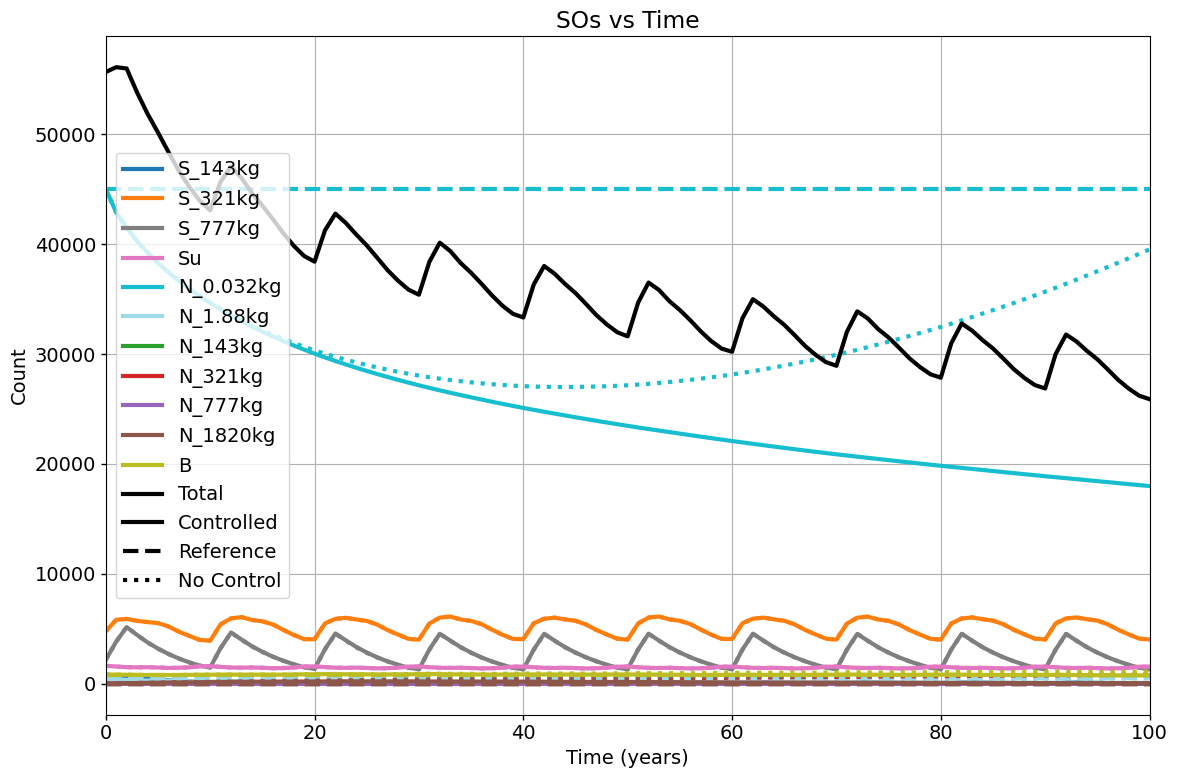

{'B': array([853.        , 838.44877253, 830.67390516, 817.46707924,
       809.25345621, 809.01432523, 802.61225085, 806.83931219,
       820.57919607, 829.55373862, 834.43875536, 840.95993129,
       844.59683071, 834.94656637, 838.1527195 , 842.21800672,
       837.02697887, 841.03350724, 856.06681187, 865.92879549,
       872.95749793, 887.28360377, 882.9897309 , 874.58192754,
       873.97931807, 870.75922602, 859.03587231, 857.59370433,
       865.34088085, 869.44347029, 877.14878826, 889.53878723,
       886.88299381, 870.93023253, 861.22464647, 858.94651657,
       846.35337008, 844.924783  , 852.54491752, 858.1136472 ,
       860.13579321, 857.71431712, 860.03943225, 851.97981485,
       850.71532572, 854.21147834, 843.82299336, 843.05178756,
       852.16343079, 854.86217332, 855.54038334, 854.68554961,
       850.27968502, 840.26061717, 829.65617995, 828.60898637,
       813.3686079 , 807.25813461, 812.97268822, 819.66887533,
       823.81532207, 832.16768961, 830.4571595 , 

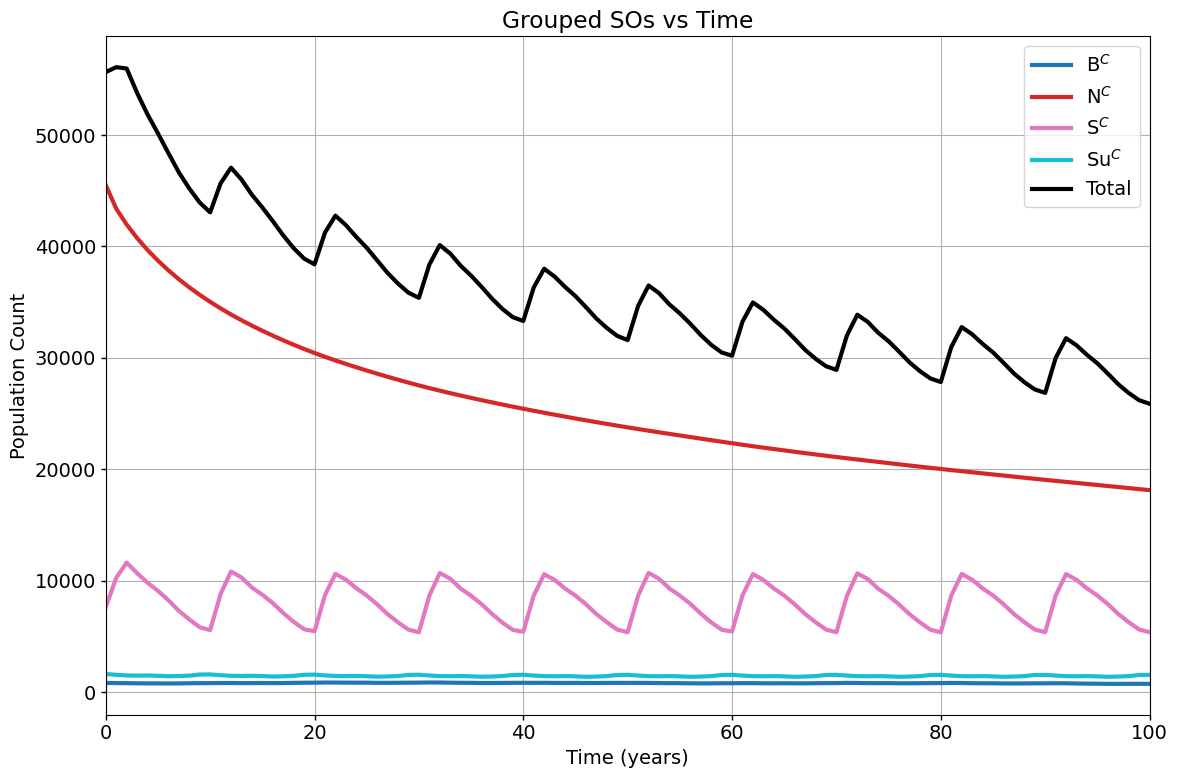

[0.95 0.96 0.97 0.98 0.99 1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.  ]
[0.95 0.96 0.97 0.98 0.99 1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.  ]


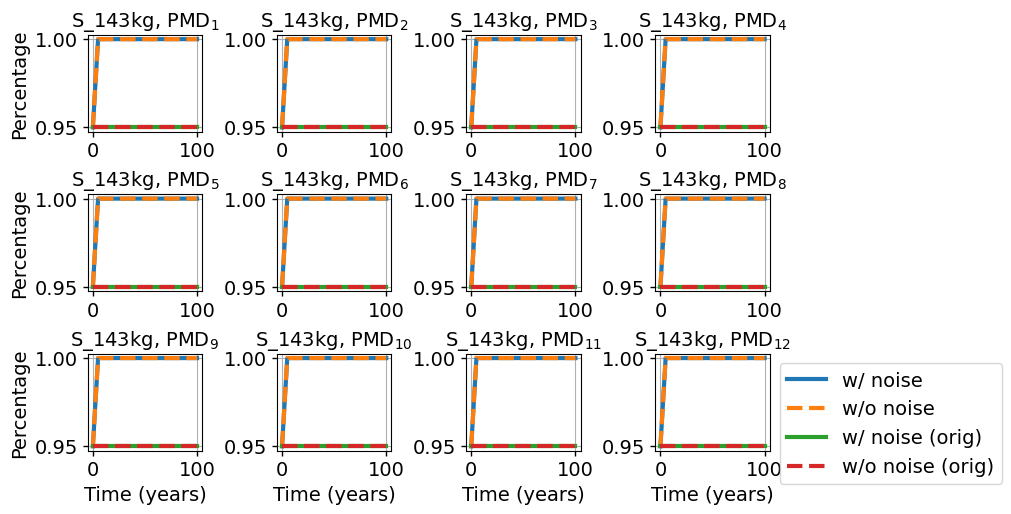

[0.95 0.96 0.97 0.98 0.99 1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.  ]
[0.95 0.96 0.97 0.98 0.99 1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.  ]


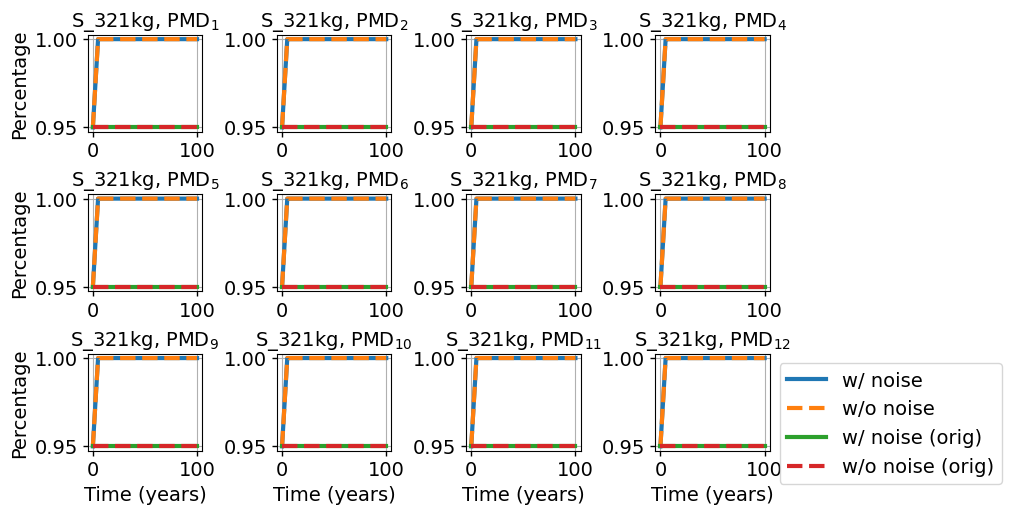

[0.95 0.96 0.97 0.98 0.99 1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.  ]
[0.95 0.96 0.97 0.98 0.99 1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.  ]


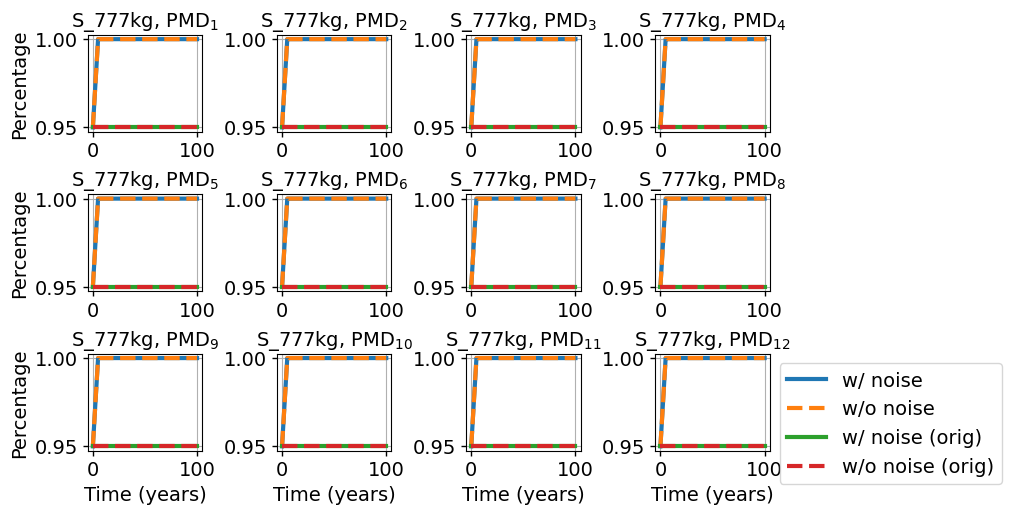

[0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69 0.7  0.71 0.71 0.71
 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.79 0.79 0.79 0.79 0.8  0.81
 0.82 0.83 0.84 0.84 0.84 0.84 0.84 0.84 0.84 0.85 0.86 0.87 0.88 0.88
 0.88 0.88 0.88 0.88 0.88 0.88 0.89 0.9  0.91 0.91 0.91 0.91 0.91 0.91
 0.91 0.91 0.92 0.93 0.94 0.94 0.94 0.94 0.94 0.94 0.94 0.94 0.94 0.95
 0.96 0.96 0.96 0.96 0.96 0.96 0.96 0.96 0.96 0.96 0.96 0.96 0.96 0.96
 0.96 0.96 0.96 0.96 0.96 0.96 0.96 0.96 0.96 0.96 0.96 0.96 0.96 0.96
 0.96 0.96 0.96]
[0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69 0.7  0.71 0.71 0.71
 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.79 0.79 0.79 0.79 0.8  0.81
 0.82 0.83 0.84 0.84 0.84 0.84 0.84 0.84 0.84 0.85 0.86 0.87 0.88 0.88
 0.88 0.88 0.88 0.88 0.88 0.88 0.89 0.9  0.91 0.91 0.91 0.91 0.91 0.91
 0.91 0.91 0.92 0.93 0.94 0.94 0.94 0.94 0.94 0.94 0.94 0.94 0.94 0.95
 0.96 0.96 0.96 0.96 0.96 0.96 0.96 0.96 0.96 0.96 0.96 0.96 0.96 0.96
 0.96 0.96 0.96 0.96 0.96 0.96 0.96 0.96 0.96 0.96 0.96 0.96

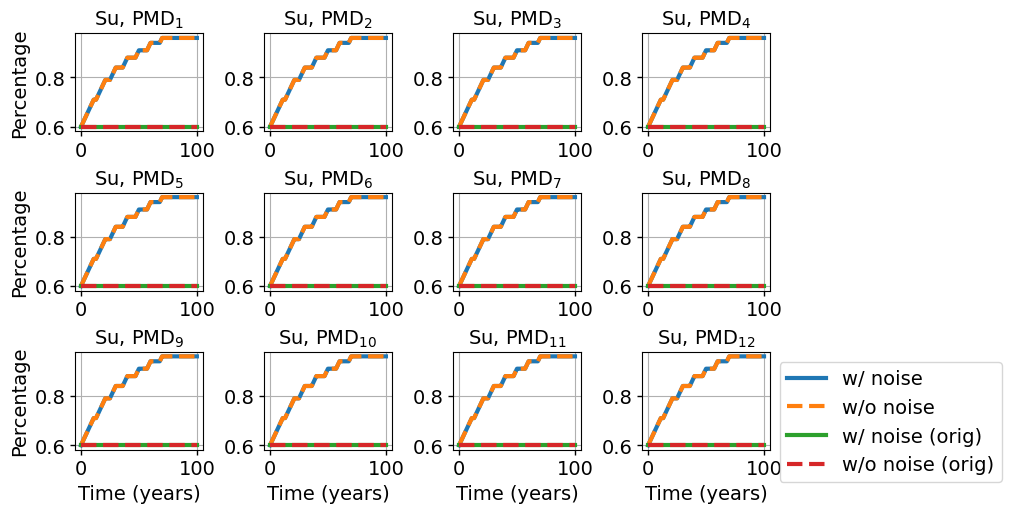

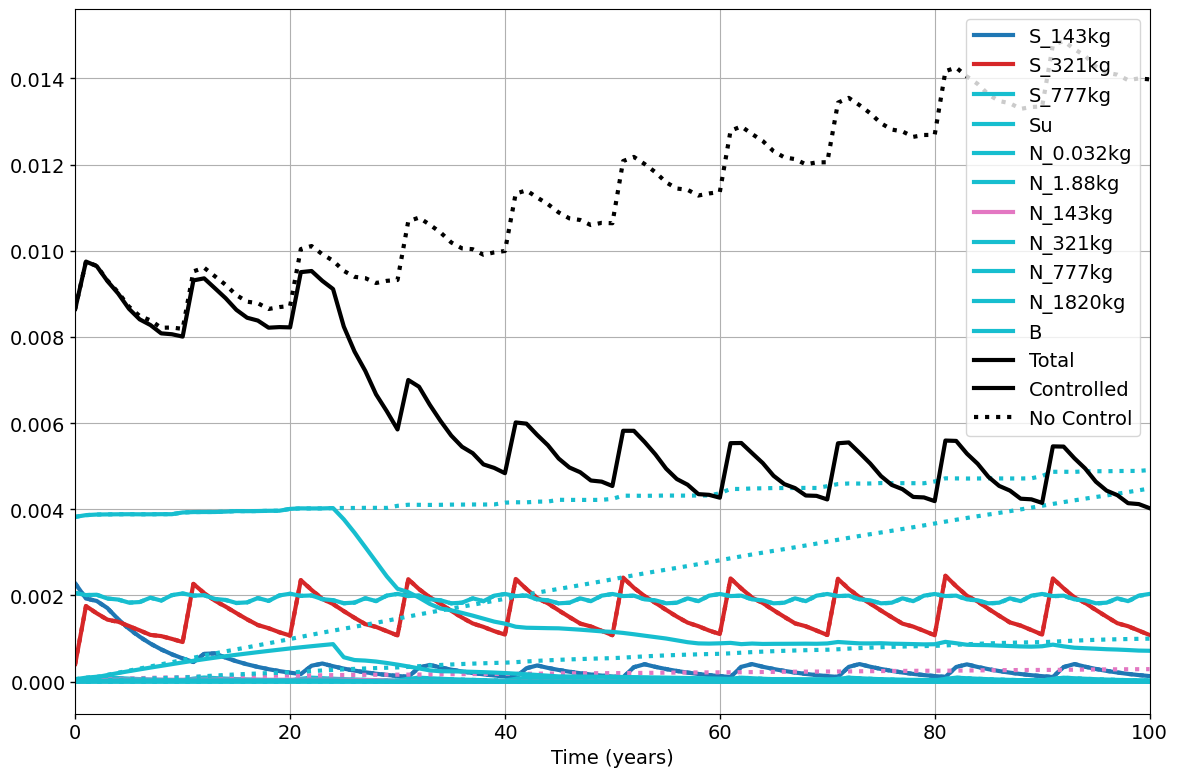

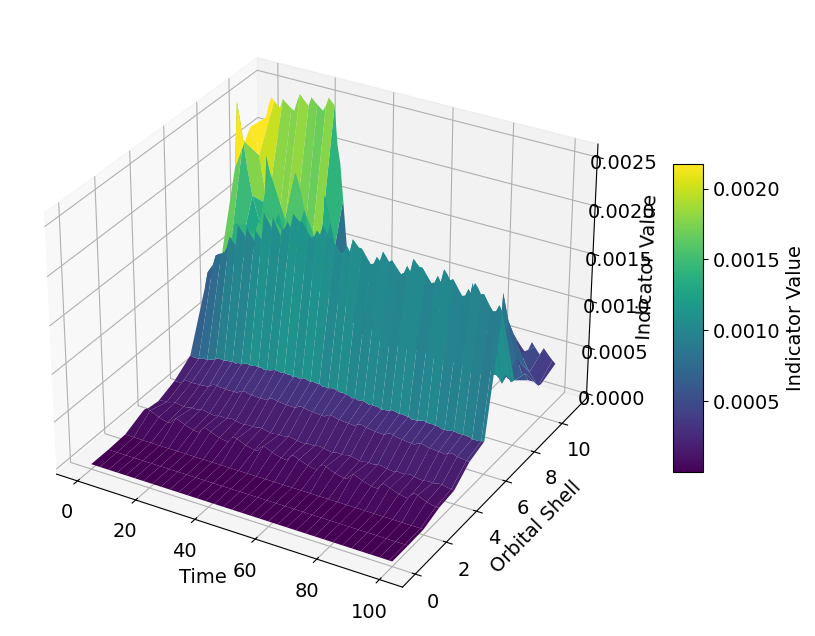

[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0. -10. -10. -10. -10. -10. -10.
 -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10.
 -10. -10. -10. -10. -10. -15. -15. -15. -15. -15. -15. -15. -15. -15.
 -15. -15. -15. -15. -15. -15. -15. -15. -15. -15. -15. -15. -15. -15.
 -15. -15. -20.]


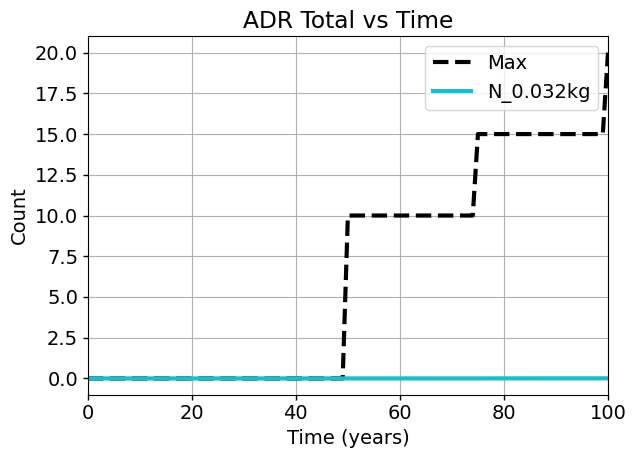

[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  -5.  -5.  -5.
  -5.  -5.  -5.  -5.  -5.  -5.  -5.  -5.  -5.  -5.  -5.  -5.  -5.  -5.
  -5.  -5.  -5.  -5.  -5.  -5.  -5.  -5. -10. -10. -10. -10. -10. -10.
 -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10.
 -10. -10. -10. -10. -10. -15. -15. -15. -15. -15. -15. -15. -15. -15.
 -15. -15. -15. -15. -15. -15. -15. -15. -15. -15. -15. -15. -15. -15.
 -15. -15. -20.]


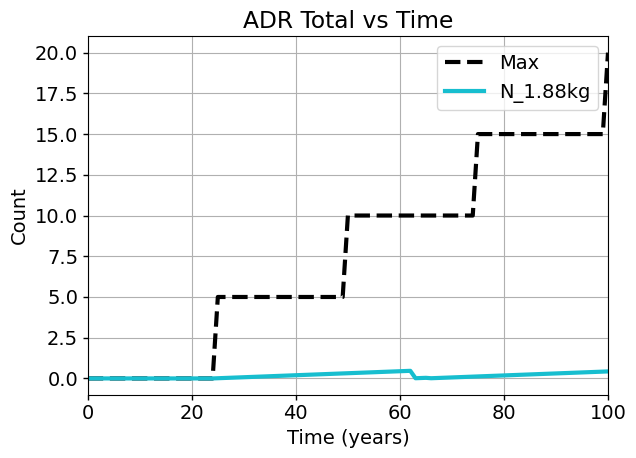

[ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -5.  -5.  -5.
  -5.  -5.  -5.  -5.  -5.  -5.  -5.  -5.  -5.  -5.  -5.  -5.  -5.  -5.
  -5.  -5.  -5.  -5.  -5.  -5.  -5.  -5. -10. -10. -10. -10. -10. -10.
 -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10.
 -10. -10. -10. -10. -10. -15. -15. -15. -15. -15. -15. -15. -15. -15.
 -15. -15. -15. -15. -15. -15. -15. -15. -15. -15. -15. -15. -15. -15.
 -15. -15. -20.]


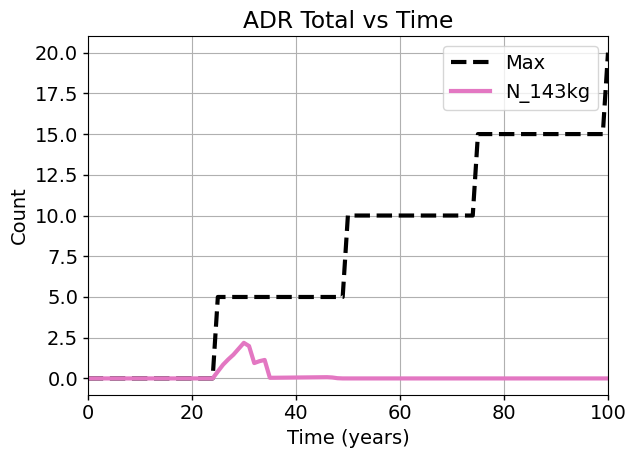

[ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -5.  -5.  -5.
  -5.  -5.  -5.  -5.  -5.  -5.  -5.  -5.  -5.  -5.  -5.  -5.  -5.  -5.
  -5.  -5.  -5.  -5.  -5.  -5.  -5.  -5. -10. -10. -10. -10. -10. -10.
 -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10.
 -10. -10. -10. -10. -10. -15. -15. -15. -15. -15. -15. -15. -15. -15.
 -15. -15. -15. -15. -15. -15. -15. -15. -15. -15. -15. -15. -15. -15.
 -15. -15. -20.]


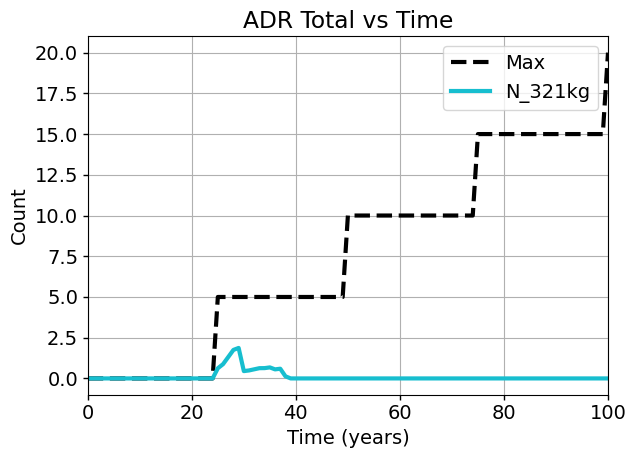

[ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -5.  -5.  -5.
  -5.  -5.  -5.  -5.  -5.  -5.  -5.  -5.  -5.  -5.  -5.  -5.  -5.  -5.
  -5.  -5.  -5.  -5.  -5.  -5.  -5.  -5. -10. -10. -10. -10. -10. -10.
 -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10.
 -10. -10. -10. -10. -10. -15. -15. -15. -15. -15. -15. -15. -15. -15.
 -15. -15. -15. -15. -15. -15. -15. -15. -15. -15. -15. -15. -15. -15.
 -15. -15. -20.]


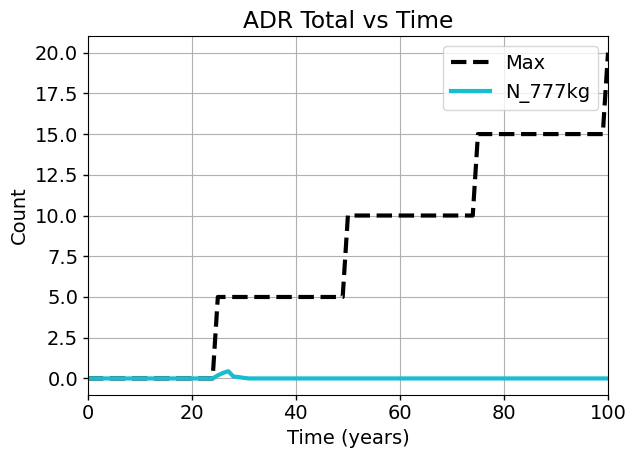

[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  -5.  -5.  -5.
  -5.  -5.  -5.  -5.  -5.  -5.  -5.  -5.  -5.  -5.  -5.  -5.  -5.  -5.
  -5.  -5.  -5.  -5.  -5.  -5.  -5.  -5. -10. -10. -10. -10. -10. -10.
 -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10.
 -10. -10. -10. -10. -10. -15. -15. -15. -15. -15. -15. -15. -15. -15.
 -15. -15. -15. -15. -15. -15. -15. -15. -15. -15. -15. -15. -15. -15.
 -15. -15. -20.]


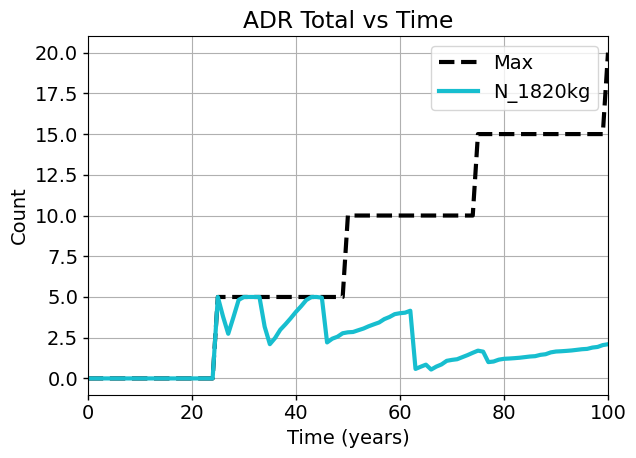

[ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -5.  -5.  -5.
  -5.  -5.  -5.  -5.  -5.  -5.  -5.  -5.  -5.  -5.  -5.  -5.  -5.  -5.
  -5.  -5.  -5.  -5.  -5.  -5.  -5.  -5. -10. -10. -10. -10. -10. -10.
 -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10.
 -10. -10. -10. -10. -10. -15. -15. -15. -15. -15. -15. -15. -15. -15.
 -15. -15. -15. -15. -15. -15. -15. -15. -15. -15. -15. -15. -15. -15.
 -15. -15. -20.]


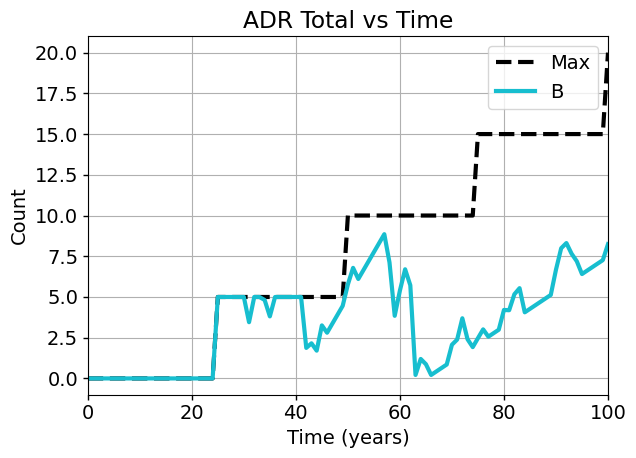

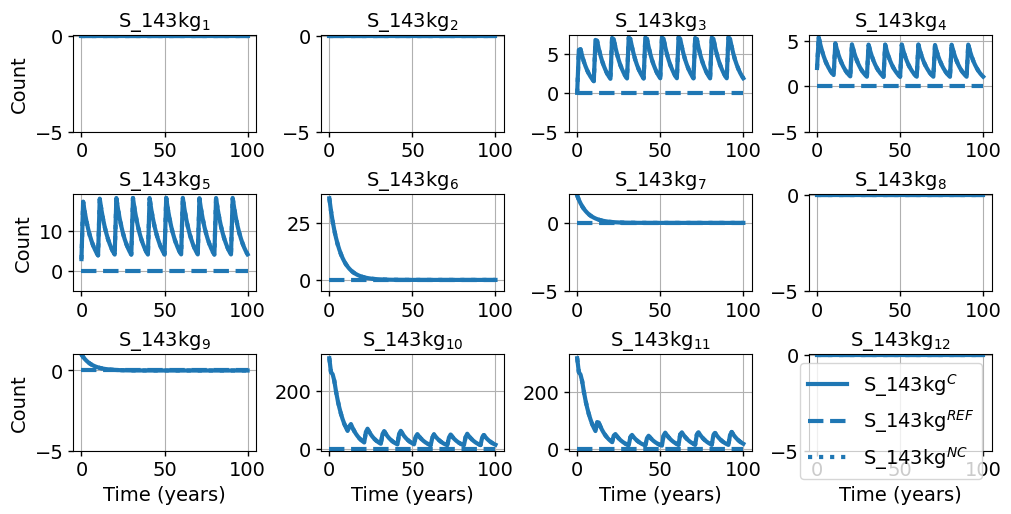

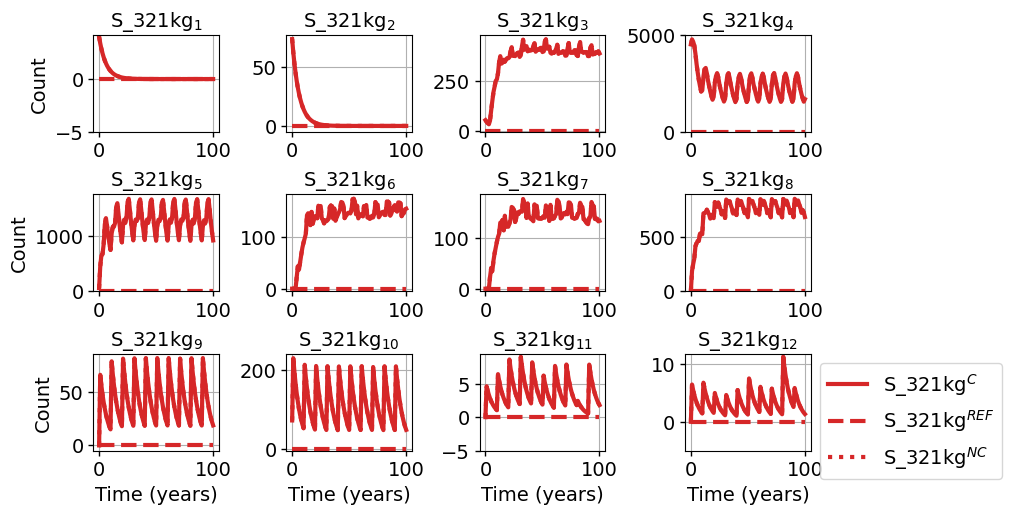

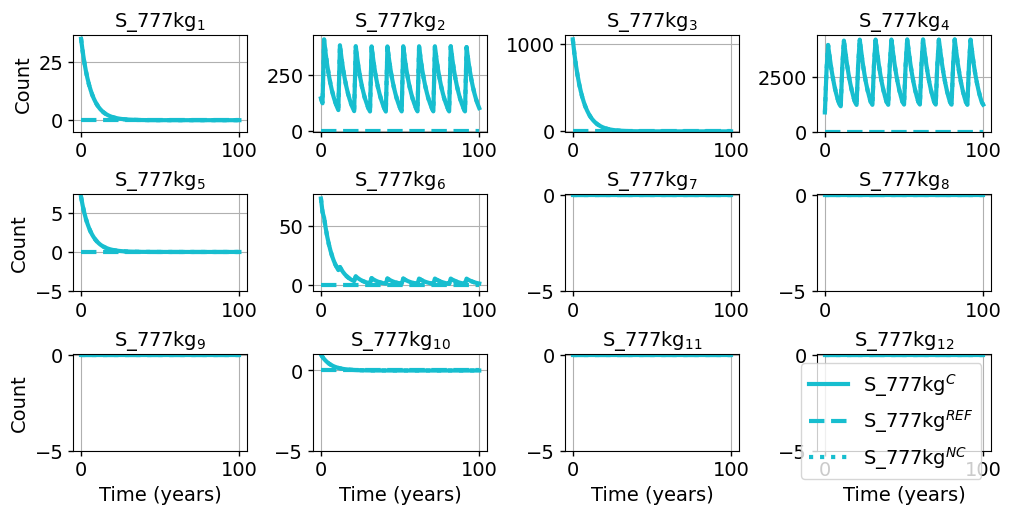

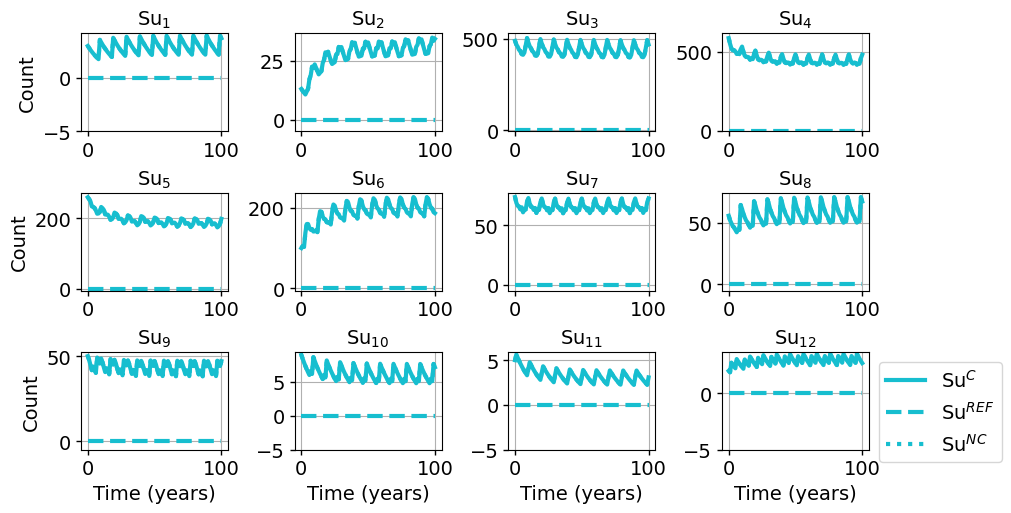

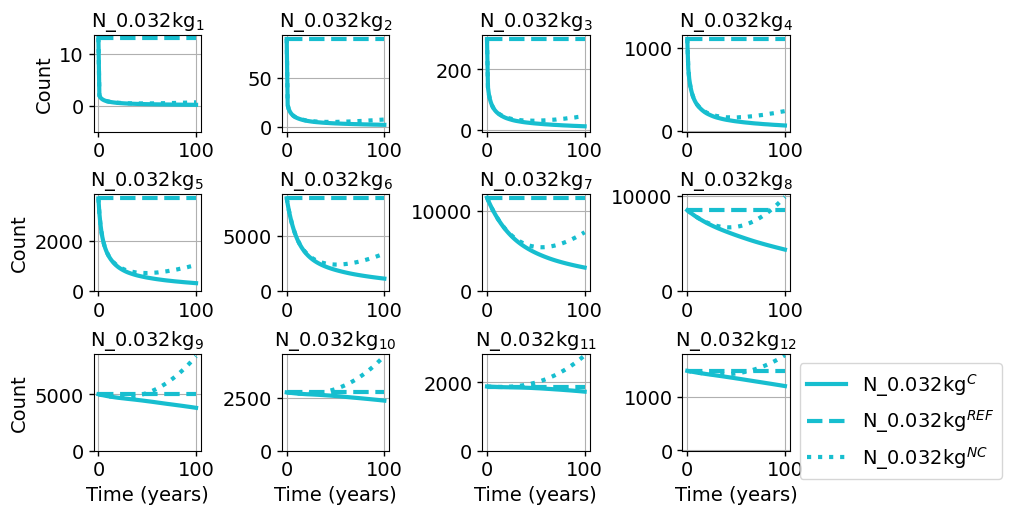

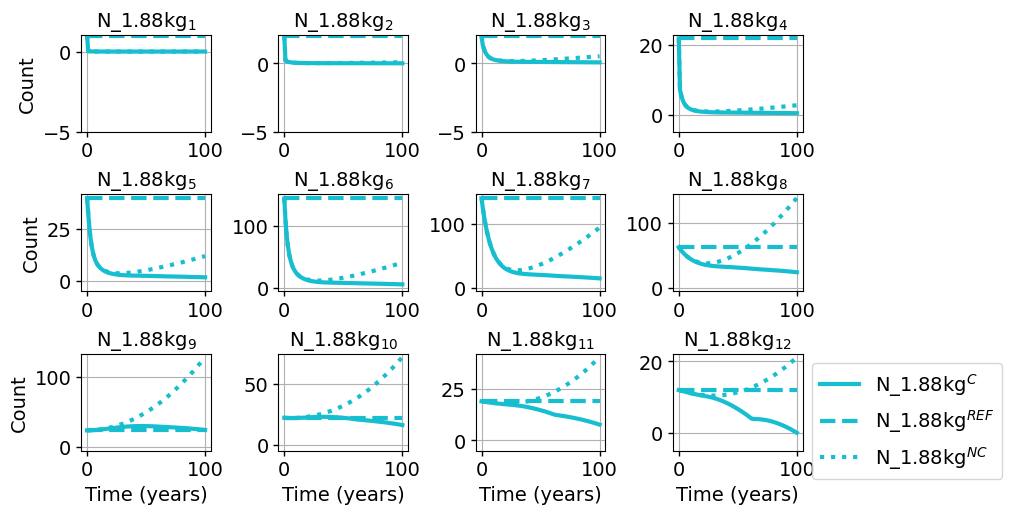

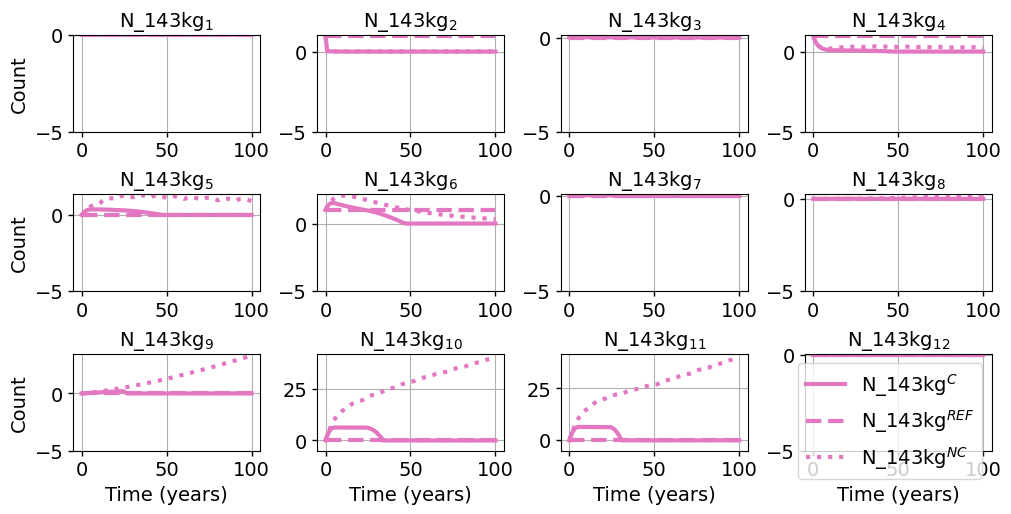

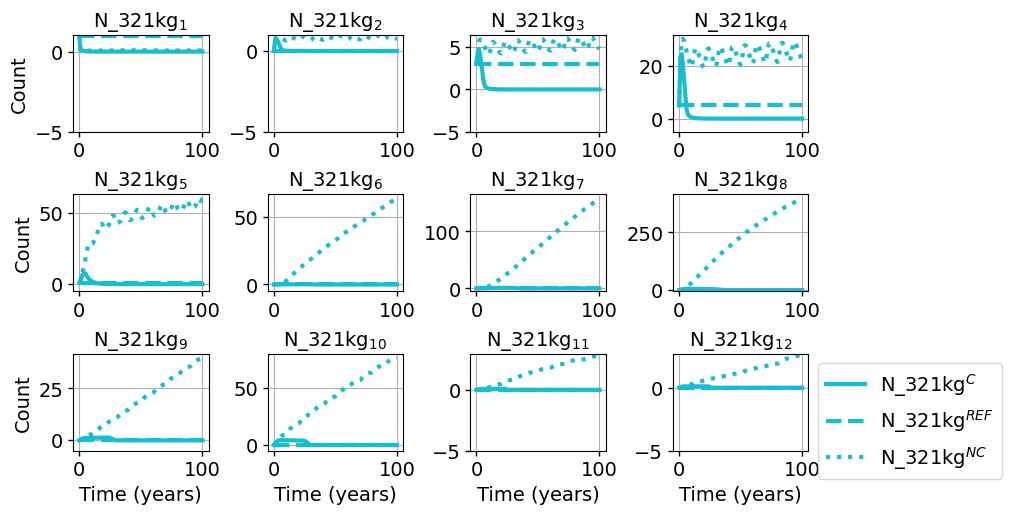

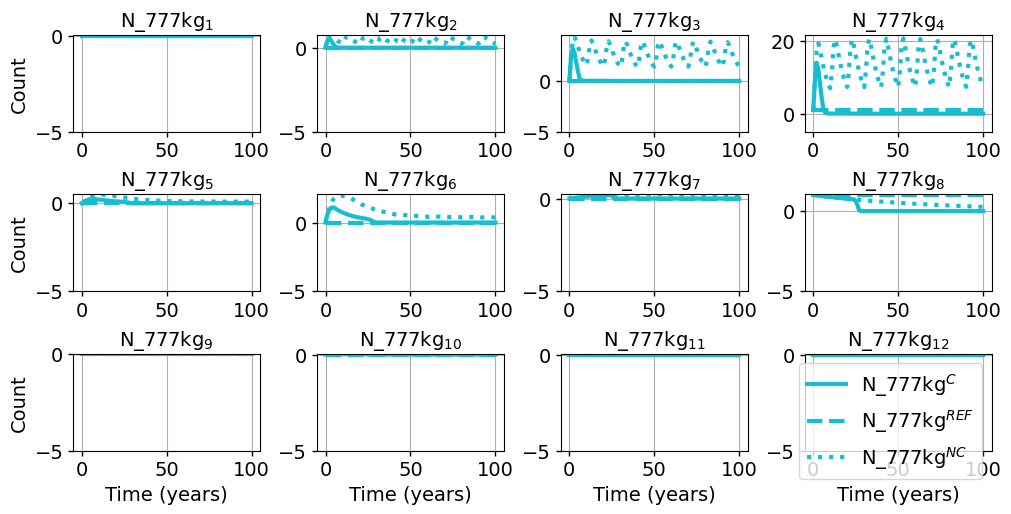

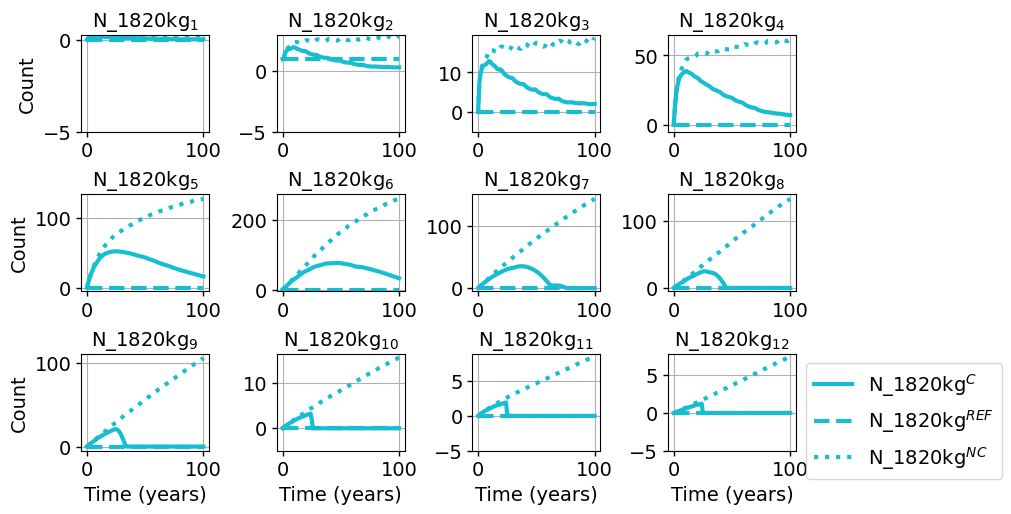

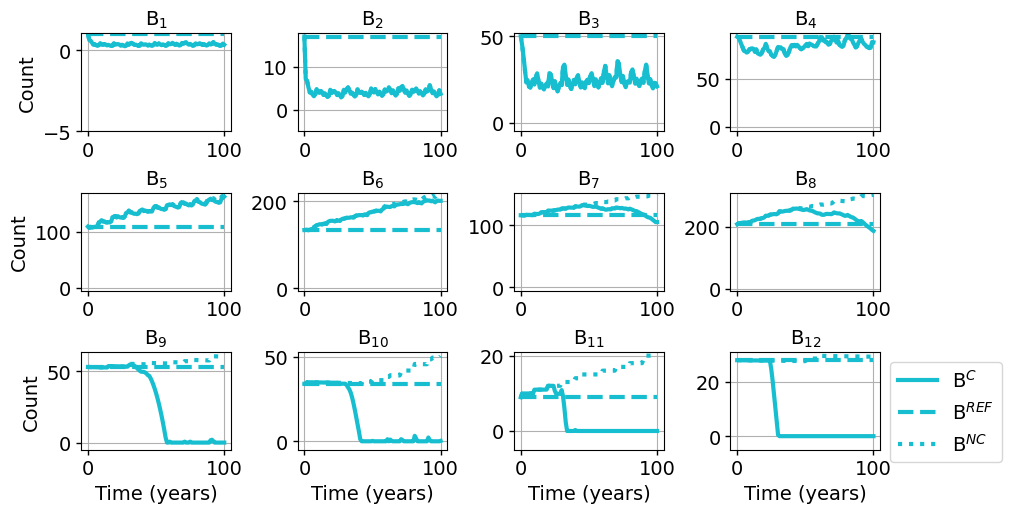

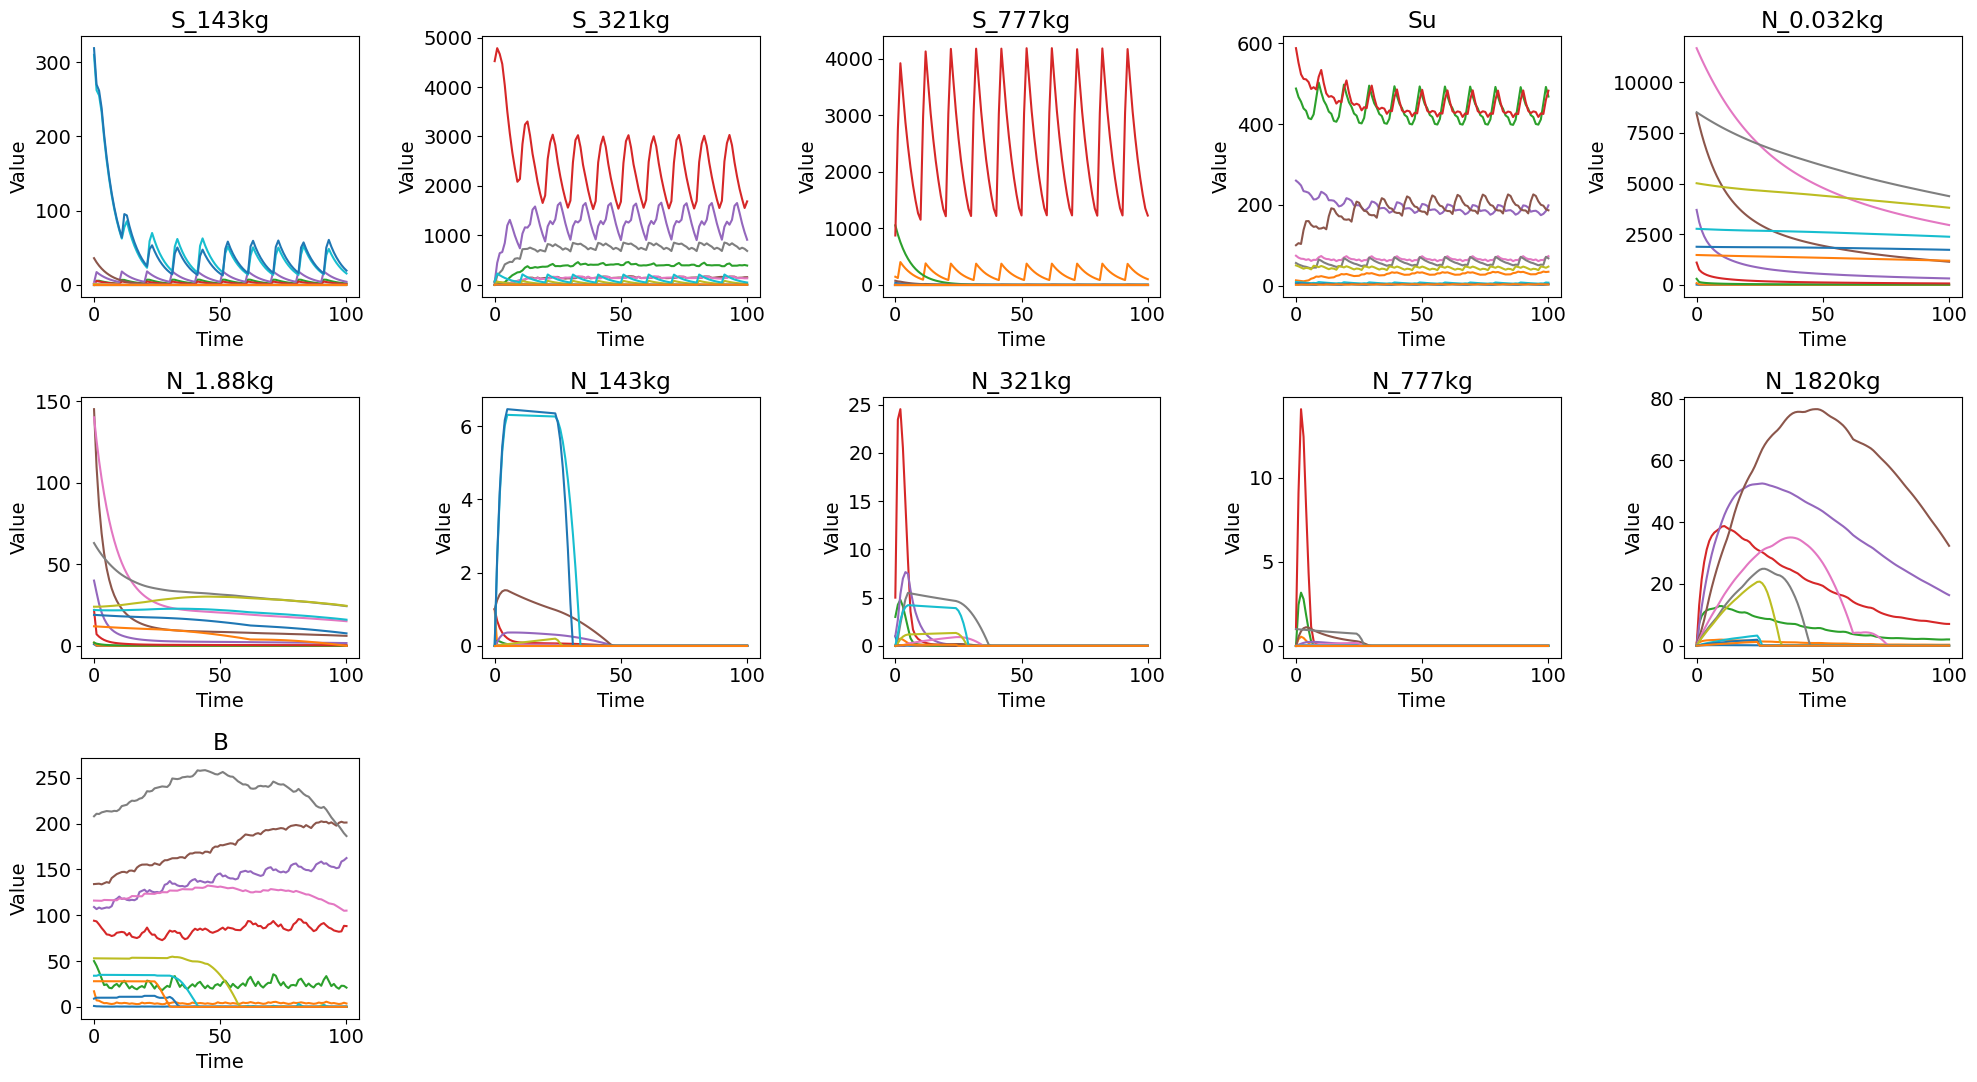

In [83]:
#==========================================================================
# Variable definition for plots
#==========================================================================
# size = (42,101)
baseline.output = {}
baseline.output['t'] = t_prop
baseline.output['y'] = xHistory
baseline.output['y_nc'] = x_prop_nc.T
baseline.output['y_u'] = mvHistory
# if sel_ic == 3:
baseline.output['y_ref'] = np.tile(ref, (len(t_prop), 1)).T
baseline.output['ydot_ref'] = np.tile(ref_dot, (len(t_prop), 1)).T
# else:
#     baseline.output['y_ref'] = np.concatenate([np.tile(ref_S, (len(t_prop), 1)), np.tile(ref_N, (len(t_prop), 1)), np.tile(ref_D, (len(t_prop), 1))], axis=1).T
#     baseline.output['ydot_ref'] = np.concatenate([np.tile(ref_S_dot, (len(t_prop), 1)), np.tile(ref_N_dot, (len(t_prop), 1)), np.tile(ref_D_dot, (len(t_prop), 1))], axis=1).T
# size = (101,)
baseline.output['satur'] = satur
baseline.output['PMD'] = PMD
baseline.output['PMD_no_noise'] = PMD_no_noise
baseline.output['PMD_orig'] = PMD_orig
baseline.output['PMD_no_noise_orig'] = PMD_no_noise_orig
if sel_risk_index == 3:
    baseline.output['risk_idx_per_species_per_shell_csi'] = risk_idx_per_species_per_shell_csi.T
    baseline.output['risk_idx_per_species_per_shell_nc_csi'] = risk_idx_per_species_per_shell_nc_csi.T
    baseline.output['risk_idx_per_species_per_shell_umpy'] = risk_idx_per_species_per_shell_umpy.T
    baseline.output['risk_idx_per_species_per_shell_nc_umpy'] = risk_idx_per_species_per_shell_nc_umpy.T
elif sel_risk_index:
    baseline.output['risk_idx_per_species_per_shell'] = risk_idx_per_species_per_shell.T
    baseline.output['risk_idx_per_species_per_shell_nc'] = risk_idx_per_species_per_shell_nc.T

output = CreateOutput(baseline.output)
n_species = baseline.species_length
num_shells = baseline.n_shells
species_names = baseline.species_names
orbital_shell_labels = baseline.R0_km[:num_shells]
markers = ['o', 's', '^', 'D', 'v', '>', '<', 'p', '*', 'h']

base_species_names = baseline.species_names
unique_base_species = list(set(base_species_names))
color_map = plt.get_cmap('tab20', len(unique_base_species))

#==========================================================================
# Plots
#==========================================================================
if sel_cumulative_plot == 1:
    cumulative_plot(baseline, output, active_species_indices, sel_pmd_control, sel_risk_index, sel_LineWidth, sel_LineWidthAxis, sel_FontSize)


CSI in last year: 0.004026146969301025
0.00865008152325094, 0.009748010395166942, 0.009642966717869761, 0.00929419918341623, 0.009005235421581005, 0.008652867408368195, 0.008406627360931054, 0.008275303347704233, 0.008082169668203645, 0.008061765795584343, 0.008007117269561936, 0.009310798433826805, 0.009358836662218133, 0.009129394893439408, 0.008897845018424153, 0.008627890631585292, 0.008444783646658065, 0.0083786892827068, 0.00821382285976821, 0.008227348048711877, 0.008220788737737288, 0.009503048569668472, 0.009529150638651713, 0.009300499691239073, 0.009110469521786933, 0.008238642311773925, 0.007659615606862941, 0.007210619285044629, 0.0066671862006424144, 0.006275534789086634, 0.005852440073381842, 0.0070004708442475035, 0.006843788946307125, 0.0064257312352011264, 0.006050921182939294, 0.005710342637135043, 0.005451388932552963, 0.005301880646342209, 0.00504184552991082, 0.004960478588966662, 0.004837430180730285, 0.0060153061725448514, 0.005987033668515979, 0.005725110166627

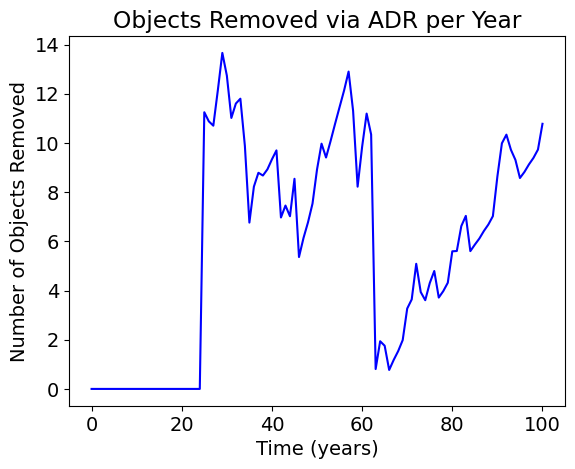

Number of objects removed N_143 per year: 
0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4257583781701394, 0.841983324057776, 1.167566002904477, 1.459566953974835, 1.822160408346558, 2.184474366014312, 1.9875797873808194, 0.9435843520630308, 1.0598321525397651, 1.133911141251362, 0.0388751386148845, 0.041782882030122925, 0.04526131264317, 0.04874007355203, 0.05221808034603, 0.05569787003768, 0.05918184996109, 0.06266414910614, 0.0661444009962, 0.06962161781551, 0.07309756826229, 0.07658208869294, 0.05797948561117, 0.01424897123122538, 0.00017458181277, 3.6963566739e-11, 0.0, 5.3188419237e-22, 1.0936005058e-10, 3.356333916494436e-17, 2.7852972068e-22, 2.6404410197024234e-10, 2.0523664999e-22, 3.0049534825405587e-16, 2.829969647685878e-16, 1.2529143223e-22, 0.0, 1.5446057767599999e-22, 1.6253217593413462e-16, 2.6068972065010425e-10, 6.678818994452562e-18, 6.8708186698e-23, 3.03686134419544e-10, 1.61491595937

In [84]:
risk_idx_total_csi = np.zeros_like(output.t)
for species_index in range(n_species):
    start_idx = species_index * num_shells
    end_idx = start_idx + num_shells
    risk_idx_per_species_csi = np.sum(output.risk_idx_per_species_per_shell_csi[start_idx:end_idx, :], axis=0)
    risk_idx_total_csi += risk_idx_per_species_csi
    #print(-np.sum(output.y_u[start_idx:end_idx, :], axis=0)[100])

print(f"CSI in last year: {risk_idx_total_csi[-1]}")
print(', '.join(map(str, risk_idx_total_csi)))

risk_idx_total_umpy = np.zeros_like(output.t)
for species_index in range(n_species):
    start_idx = species_index * num_shells
    end_idx = start_idx + num_shells
    risk_idx_per_species_umpy = np.sum(output.risk_idx_per_species_per_shell_umpy[start_idx:end_idx, :], axis=0)
    risk_idx_total_umpy += risk_idx_per_species_umpy
    #print(-np.sum(output.y_u[start_idx:end_idx, :], axis=0)[100])

print(f"UMPY in last year: {risk_idx_total_umpy[-1]}")
print(', '.join(map(str, risk_idx_total_umpy)))

species_mass = []
for species_index, (species_name, species_list) in enumerate(baseline.species_cells.items()):
    for species_properties in species_list:
        species_mass.append(species_properties.mass)
print(species_mass)


number_of_objects_removed_N = []
mass_of_objects_removed_N = []
number_of_objects_removed_B = []
mass_of_objects_removed_B = []

for species_index in range(n_species):
    if not base_species_names[species_index].startswith('S'):
        start_idx = species_index * num_shells
        end_idx = start_idx + num_shells
        if base_species_names[species_index].startswith('N'):
            number_of_objects_removed_N.append((-np.sum(output.y_u[start_idx:end_idx, :])))
            mass_of_objects_removed_N.append((-np.sum(output.y_u[start_idx:end_idx, :])) * species_mass[species_index])
        elif base_species_names[species_index].startswith('B'):
            number_of_objects_removed_B.append((-np.sum(output.y_u[start_idx:end_idx, :])))
            mass_of_objects_removed_B.append((-np.sum(output.y_u[start_idx:end_idx, :])) * species_mass[species_index])
            #print(-output.satur[species_index](output.t))

print(f"Number of objects removed (N): {sum(number_of_objects_removed_N)}")
print(f"Number of objects removed (N) in last year: {number_of_objects_removed_N[-1]}")
print(f"Mass of objects removed (N): {sum(mass_of_objects_removed_N)} kg")
print(f"Number of objects removed (B): {sum(number_of_objects_removed_B)}")
print(f"Mass of objects removed (B): {sum(mass_of_objects_removed_B)} kg")
print(f"Total number of objects removed: {sum(number_of_objects_removed_N) + sum(number_of_objects_removed_B)}")
print(f"Total mass of objects removed: {sum(mass_of_objects_removed_N) + sum(mass_of_objects_removed_B)} kg")

N_143 = 0
N_321 = 0
N_777 = 0
N_1820 = 0
N_4028 = 0
N_0_032 = 0
N_1_88 = 0
N_0_027 = 0
N_12 = 0
B = 0

N_143_count = np.zeros(len(output.t))
N_321_count = np.zeros(len(output.t))
N_777_count = np.zeros(len(output.t))
N_1820_count = np.zeros(len(output.t))
N_4028_count = np.zeros(len(output.t))
N_0_032_count = np.zeros(len(output.t))
N_1_88_count = np.zeros(len(output.t))
N_0_027_count = np.zeros(len(output.t))
N_12_count = np.zeros(len(output.t))
B_count = np.zeros(len(output.t))

ADR_money_per_year = np.zeros_like(output.t)
objects_removed_per_year = np.zeros(len(output.t))
num_objects_removed = 0

for i in range(len(tspan)):
    years_elapsed = tspan[i]  # assuming tspan is in years
    for species_index in range(n_species):
        start_idx = species_index * num_shells
        end_idx = start_idx + num_shells
        if not base_species_names[species_index].startswith('S'):
            removed = -np.sum(output.y_u[start_idx:end_idx, :], axis=0)[i]
            num_objects_removed += removed

            if base_species_names[species_index].startswith('N_143'):
                #cost = 500000 * (0.97 ** years_elapsed)
                cost = 8380000 * (0.97 ** years_elapsed)
                N_143 += removed * cost 
                N_143_count[i] += removed
            elif base_species_names[species_index].startswith('N_321'):
                #cost = 500000 * (0.97 ** years_elapsed)
                cost = 19300000 * (0.97 ** years_elapsed)
                N_321 += removed * cost
                N_321_count[i] += removed
            elif base_species_names[species_index].startswith('N_777'):
                #cost = 1200000 * (0.97 ** years_elapsed)
                cost = 17800000 * (0.97 ** years_elapsed)
                N_777 += removed * cost
                N_777_count[i] += removed
            elif base_species_names[species_index].startswith('N_1820'):
                #cost = 2400000 * (0.97 ** years_elapsed)
                cost = 17800000 * (0.97 ** years_elapsed)
                N_1820 += removed * cost
                N_1820_count[i] += removed
            elif base_species_names[species_index].startswith('N_4028'):
                cost = 26500000 * (0.97 ** years_elapsed)
                N_4028 += removed * cost
                N_4028_count[i] += removed
            elif base_species_names[species_index].startswith('N_0.032'):
                #cost = 300000 * (0.97 ** years_elapsed), formerly all small 
                cost = 7600000 * (0.97 ** years_elapsed)
                N_0_032 += removed * cost
                N_0_032_count[i] += removed
            elif base_species_names[species_index].startswith('N_1.88'):
                cost = 7940000 * (0.97 ** years_elapsed)
                N_1_88 += removed * cost
                N_1_88_count[i] += removed
            elif base_species_names[species_index].startswith('N_0.027'):
                cost = 7600000 * (0.97 ** years_elapsed)
                N_0_027 += removed * cost
                N_0_027_count[i] += removed
            elif base_species_names[species_index].startswith('N_0.125'):
                cost = 5940000 * (0.97 ** years_elapsed)
                N_12 += removed * cost
                N_12_count[i] += removed
            elif base_species_names[species_index].startswith('B'):
                #cost = 2000000 * (0.97 ** years_elapsed)
                cost = 24400000 * (0.97 ** years_elapsed)
                B += removed * cost
                B_count[i] += removed

    objects_removed_per_year[i] = num_objects_removed
    ADR_money_per_year[i] = N_143 + N_321 + N_777 + N_1820 + N_4028 + N_0_032 + N_1_88 + N_0_027 + N_12 + B

    # Reset counters for next year
    num_objects_removed = 0
    N_143 = 0
    N_321 = 0
    N_777 = 0
    N_1820 = 0
    N_4028 = 0
    N_0_032 = 0
    N_1_88 = 0
    N_0_027 = 0
    N_12 = 0
    B = 0

print(', '.join(map(str, objects_removed_per_year)))
print(f"Maximum number of objects removed in one year: {max(objects_removed_per_year)}")
print(f"Number of objects removed in last year: {objects_removed_per_year[-1]}")
print("Cost of ADR per year:")
print(', '.join(map(str, ADR_money_per_year)))

plt.plot(output.t, objects_removed_per_year, label='Objects Removed per Year', color='blue')
plt.xlabel('Time (years)')
plt.ylabel('Number of Objects Removed')
plt.title('Objects Removed via ADR per Year')
plt.show()

print("Number of objects removed N_143 per year: ")
print(', '.join(map(str, N_143_count)))
print("Number of objects removed N_321 per year: ")
print(', '.join(map(str, N_321_count)))
print("Number of objects removed N_777 per year: ")
print(', '.join(map(str, N_777_count)))
print("Number of objects removed N_1820 per year: ")
print(', '.join(map(str, N_1820_count)))
print("Number of objects removed N_4028 per year: ")
print(', '.join(map(str, N_4028_count)))
print("Number of objects removed N_0.032 per year: ")
print(', '.join(map(str, N_0_032_count)))
print("Number of objects removed N_1.88 per year: ")
print(', '.join(map(str, N_1_88_count)))
print("Number of objects removed N_0.027 per year: ")
print(', '.join(map(str, N_0_027_count)))
print("Number of objects removed N_12 per year: ")
print(', '.join(map(str, N_12_count)))
print("Number of objects removed B per year: ")
print(', '.join(map(str, B_count)))

# print("Number of objects removed N_143: ", {N_143_count})
# print("Number of objects removed N_321: ", {N_321_count})
# print("Number of objects removed N_777: ", {N_777_count})
# print("Number of objects removed N_1820: ", {N_1820_count})
# print("Number of objects removed N_4028: ", {N_4028_count})
# print("Number of objects removed N_0.032: ", {N_0_032_count})
# print("Number of objects removed N_1.88: ", {N_1_88_count})
# print("Number of objects removed N_0.027: ", {N_0_027_count})
# print("Number of objects removed N_12: ", {N_12_count})
# print("Number of objects removed B: ", {B_count})


In [85]:
#==========================================================================
# Collision rate
#==========================================================================
# The description of make_active_loss_per_shell says: 
# "Calculates the indicator variable for number of active spacecraft lost in each orbit shell to collision events in a given year. "
# In a 3 species case, I would have those: col_rate_SS, col_rate_SD, col_rate_SN, col_rate_DD, col_rate_DN, col_rate_NN. 
# Each indicator represents the collision rate of a species versus all the other ones:
# - S_aggregate_collisions = col_rate_SS + col_rate_SD + col_rate_SN
# - N_aggregate_collisions = col_rate_SN + col_rate_DN + col_rate_NN
# - N_200kg_aggregate_collisions = col_rate_SD + col_rate_DD + col_rate_DN

from utils.indicators.indicators import make_active_loss_per_shell

baseline.indicator_variables_list = []
percentage = False  # False uses absolute number, true gives the percentage
per_species = True # True returns values for each species as independent, false sums by shell
per_pair = False
baseline.indicator_variables_list.append(make_active_loss_per_shell(baseline, percentage, per_species, per_pair))

baseline.indicator_results['indicators'] = {}
for i in baseline.indicator_variables_list:
    for indicator_var in i:
        simplified_eqs = sp.simplify(indicator_var.eqs)
        indicator_fun = sp.lambdify(baseline.all_symbolic_vars, simplified_eqs, 'numpy')
        evaluated_indicator_dict = {}
        # Iterate over states (rows in y) and corresponding time steps (t)
        for state, t in zip(output.y.T, output.t):
            evaluated_value = indicator_fun(*state)
            evaluated_indicator_dict[t] = evaluated_value
        # Store the results for this indicator in the results dictionary
        baseline.indicator_results['indicators'][indicator_var.name] = evaluated_indicator_dict

collision_rate = {}
for indicator_name, time_values in baseline.indicator_results['indicators'].items():
    print(f"Indicator: {indicator_name}")
    times = np.array(list(time_values.keys()))  # Time array
    indicator_matrix = np.array([np.squeeze(values) for values in time_values.values()])  # Shape: [num_times, num_shells]
    collision_rate_per_year = np.sum(indicator_matrix, axis=1)
    collision_rate[indicator_name[:-21]] = {
        'times': times,
        'indicator_matrix': indicator_matrix, # The full (times x shells) matrix
        'rate_per_year': collision_rate_per_year # The summed (times,) vector
    }

# # Example: How to access and use the results
# print("\n--- Final Processed Collision Rate Results ---")
# for species_name, results_dict in collision_rate.items():
#     print(f"Results for: {species_name}")
#     print(f"  - Shape of matrix (times x shells): {results_dict['indicator_matrix'].shape}")
#     print(f"  - Total collision rate in the first year: {results_dict['rate_per_year'][0]:.2f}")


#==========================================================================
# Conjunction rate | Collision Avoidance (CA) Counter
#==========================================================================
from utils.indicators.indicators import make_ca_counter
# make_ca_counter(scen_properties, primary_species_list, secondary_species_list, per_species=False, ind_name="", per_spacecraft=False)

# 1. Create a lookup dictionary for fast access to species properties by name.
# This is much more efficient than searching in a loop.
species_props_map = {
    prop.sym_name: prop 
    for species_list in baseline.species_cells.values() 
    for prop in species_list
}

# This dictionary will store the final, processed results.
ca_counter_results = {}

print("\n--- Generating and Evaluating CA Counter Indicators ---")

# 2. Outer loop: Iterate through each species using your robust method.
for species_class, species_list_in_class in baseline.species_cells.items():
    for primary_species_properties in species_list_in_class:
        
        # Filter for active primary species
        if not primary_species_properties.sym_name.startswith('S'):
            continue

        primary_species_name = primary_species_properties.sym_name
        #print(f"Processing CAMs for primary species: {primary_species_name}...")
        
        # Initialize a symbolic expression to accumulate the total CAs
        total_ca_eqs_for_primary = sp.zeros(baseline.n_shells, 1)

        # 3. Inner loop: Sum the interactions with all other species
        for secondary_species_name in baseline.species_names:
        
            # Retrieve the full properties object for the secondary species using our map.
            secondary_species_properties = species_props_map[secondary_species_name]
            
            # Now pass the full objects to the function.
            indicator_var_list = make_ca_counter(
                baseline,
                primary_species_list=[primary_species_properties],
                secondary_species_list=[secondary_species_properties]
            )

            # Check if the returned list is not empty before trying to access its elements.
            # Then, access the first element [0] to get the actual indicator object.
            if indicator_var_list and indicator_var_list[0].eqs is not None:
                total_ca_eqs_for_primary += indicator_var_list[0].eqs

        # 4. Lambdify, evaluate, and store the results (this part remains the same)
        simplified_eqs = sp.simplify(total_ca_eqs_for_primary)
        indicator_fun = sp.lambdify(baseline.all_symbolic_vars, simplified_eqs, 'numpy')

        evaluated_indicator_dict = {}
        for state, t in zip(output.y.T, output.t):
            evaluated_value = indicator_fun(*state)
            evaluated_indicator_dict[t] = evaluated_value

        times = np.array(list(evaluated_indicator_dict.keys()))
        indicator_matrix = np.array([np.squeeze(values) for values in evaluated_indicator_dict.values()])
        ca_maneuvers_per_year = np.sum(indicator_matrix, axis=1)

        ca_counter_results[primary_species_name] = {
            'times': times,
            'indicator_matrix': indicator_matrix,
            'maneuvers_per_year': ca_maneuvers_per_year
        }

# # Example: How to access and use the results
# print("\n--- Final Processed CA Counter Results ---")
# for species_name, results_dict in ca_counter_results.items():
#     print(f"Results for: {species_name}")
#     print(f"  - Shape of matrix (times x shells): {results_dict['indicator_matrix'].shape}")
#     print(f"  - Total maneuvers in the first year: {results_dict['maneuvers_per_year'][0]:.2f}")


Indicator: S_143kg_aggregate_collisions
Indicator: S_321kg_aggregate_collisions
Indicator: S_777kg_aggregate_collisions
Indicator: Su_aggregate_collisions
Indicator: N_0.032kg_aggregate_collisions
Indicator: N_1.88kg_aggregate_collisions
Indicator: N_143kg_aggregate_collisions
Indicator: N_321kg_aggregate_collisions
Indicator: N_777kg_aggregate_collisions
Indicator: N_1820kg_aggregate_collisions
Indicator: B_aggregate_collisions

--- Generating and Evaluating CA Counter Indicators ---


money_lost_per_year_collisions
330741879.9497462, 284156498.27431655, 256058656.35031003, 250951458.40478718, 244988397.4414417, 231328511.90406975, 209363513.07330635, 203307542.57929125, 195336475.41203356, 203176666.5539524, 200089564.1711578, 189889256.64695492, 178947510.137735, 179955357.85508025, 179212296.39272448, 172756412.88660532, 159376887.19583768, 158390081.35420373, 153876356.04304653, 163298445.60103995, 161896939.34822395, 154423544.76401627, 146520729.73632932, 147333325.76940513, 147315069.38665634, 142888469.037796, 132735212.75931408, 133429541.5454992, 130319983.55121753, 139830125.98421463, 139136650.04713622, 133076735.34031105, 126660102.68603125, 127280126.4397493, 127552175.54029171, 124120540.83077899, 115787966.076725, 117242017.24040578, 114814486.103427, 124014850.68946812, 123761778.13098, 118526633.39000845, 113034739.51556139, 113462337.37957793, 113852586.7788964, 110974315.21109475, 103821348.52298099, 105592861.93663786, 103549486.9438564, 11228298

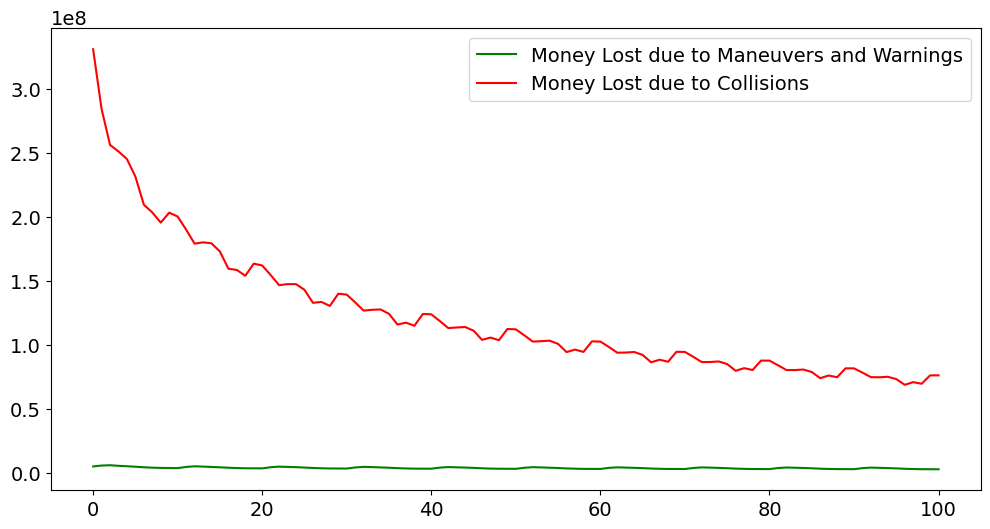

In [86]:
total_objects_per_species = np.zeros((n_species, output.y.shape[1])) # shape: (n_species, n_time_steps)
use_external_data = 1 # Set to 1 if using external data, 0 otherwise

for species_index in range(n_species):
    start_idx = species_index * num_shells
    end_idx = start_idx + num_shells
    # Sum across shells for this species at each time step
    total_objects_per_species[species_index, :] = np.sum(output.y[start_idx:end_idx, :], axis=0)

maneuvers_per_year = np.zeros(len(tspan)) # Store result for each time step
warnings_per_year = np.zeros(len(tspan)) # Store result for each time step
collisions_per_year = np.zeros(len(tspan)) # Store result for each time step
money_lost_per_year = np.zeros(len(tspan)) # Store result for each time step
money_lost_per_year_collisions = np.zeros(len(tspan)) # Store result for each time step
money_lost_per_year_maneuvers = np.zeros(len(tspan)) # Store result for each time step
total_pop = np.zeros(len(tspan)) # Store total population for each time step
debris_pop = np.zeros(len(tspan)) # Store debris population for each time step
debris_pop_non_LNT = np.zeros(len(tspan)) # Store debris population for each time step
debris_pop_LNT = np.zeros(len(tspan)) # Store debris population for each time step

for i in range(len(tspan)):
    N = np.sum(total_objects_per_species[:, i]) # Total number of objects at time step i
    total_pop[i] = N # Store total population for each time step
    N_S = total_objects_per_species[0, i] + total_objects_per_species[1, i] + total_objects_per_species[2, i] # Number of objects for species S
    N_Su = total_objects_per_species[3, i]  # Number of objects for species Su
    N_B = total_objects_per_species[10, i]
    N_N = N - N_S - N_Su - N_B - total_objects_per_species[4, i] # Number of objects for species N
    N_no_LNT = N_S + N_Su + N_B + N_N # Total number of objects excluding LNT species
    N_N_LNT = N - N_S - N_Su - N_B
    debris_pop[i] = N_N_LNT
    debris_pop_non_LNT[i] = N_N
    debris_pop_LNT[i] = N_N_LNT - N_N
    #print(N_N)

    money_lost_S = (collision_rate['S_321kg']['rate_per_year'][i] * 1000000) + ((collision_rate['S_143kg']['rate_per_year'][i] * 1000000) + (collision_rate['S_777kg']['rate_per_year'][i]) * 20000000)
    money_lost_Su_col = (collision_rate['Su']['rate_per_year'][i] * 820000000)

    if use_external_data == 0:
        money_lost_Su_man = (results_dict['maneuvers_per_year'][i] * total_objects_per_species[3, i]/(N_S + N_Su) * 770) + (results_dict['maneuvers_per_year'][i] * total_objects_per_species[4, i]/(N_S + N_Su) * 694)
        money_lost_Su_warn = ((results_dict['maneuvers_per_year'][i] * total_objects_per_species[3, i]/(N_S + N_Su) * 154) + (results_dict['maneuvers_per_year'][i] * total_objects_per_species[4, i]/(N_S + N_Su) * 3)) * 100
        money_lost_Su = money_lost_Su_col + money_lost_Su_man + money_lost_Su_warn
        #print(f"Year {i}: Money lost due to collisions: {money_lost_per_year_collisions[i]}, Maneuvers and warnings: {money_lost_per_year_maneuvers[i]}, Total: {money_lost_per_year[i]}")

    elif use_external_data == 1:
        maneuvers_per_year[i] = 0.00496 * N_no_LNT + 4.380
        money_lost_Su_man = (maneuvers_per_year[i] * (total_objects_per_species[3, i]/(N_S + N_Su) * 770)) + (maneuvers_per_year[i] * (total_objects_per_species[4, i]/(N_S + N_Su) * 694))
        warnings_per_year[i] = 1e-3 * (N_no_LNT ** 2)
        money_lost_Su_warn = ((warnings_per_year[i] * total_objects_per_species[3, i]/(N_S + N_Su) * 154) + (warnings_per_year[i] * total_objects_per_species[4, i]/(N_S + N_Su) * 3))
        money_lost_Su = money_lost_Su_col + money_lost_Su_man + money_lost_Su_warn
        
        #print(f"Maneuver per year - my equation: {maneuvers_per_year[i]}")
        #print(f"Maneuvers per year - SSEM count: {results_dict['maneuvers_per_year'][i]} ")
    
    money_lost_per_year[i] = money_lost_S + money_lost_Su
    money_lost_per_year_collisions[i] = money_lost_S + money_lost_Su_col
    money_lost_per_year_maneuvers[i] = money_lost_Su_man + money_lost_Su_warn

plt.figure(figsize=(12, 6))
#plt.plot(tspan, money_lost_per_year, label='Total Money Lost', color='blue')
#plt.plot(tspan, money_lost_per_year_collisions, label='Money Lost due to Collisions', color='red', linestyle='--')
plt.plot(tspan, money_lost_per_year_maneuvers, label='Money Lost due to Maneuvers and Warnings', color='green')
plt.plot(tspan, money_lost_per_year_collisions, label='Money Lost due to Collisions', color='red')
plt.legend()

print('money_lost_per_year_collisions')
print(', '.join(map(str, money_lost_per_year_collisions)))
print('money_lost_per_year_maneuvers')
print(', '.join(map(str, money_lost_per_year_maneuvers)))
print('total pop')
print(', '.join(map(str, total_pop)))
print(f"Total population at year 100: {total_pop[-1]}")
print('debris pop')
print(', '.join(map(str, debris_pop)))
print(f"Debris population at year 100: {debris_pop[-1]}")
print(', '.join(map(str, debris_pop_LNT)))
print(', '.join(map(str, debris_pop_non_LNT)))
print(f"Big debris population at year 100: {debris_pop_non_LNT[-1]}")
print(f"LNT population at year 100: {debris_pop_LNT[-1]}")


print(f"Number of objects in species S at year 100: {N_S}")
print(f"Number of objects in species Su at year 100: {N_Su}")
print(f"Number of objects in species N at year 100: {N_N_LNT}")
print(f"Number of objects in species B at year 100: {N_B}")
print(f"Cumulative lost due to collisions in 100 years: {np.sum(money_lost_per_year_collisions)}")
print(f"Cumulative lost due to maneuvers in 100 years: {np.sum(money_lost_per_year_maneuvers)}")
#SEP 2 = 364531142, SEP 3 = 1405685879.7445874 + 19301712.678143542, SEP4 = 3228876383.728807 + 35525132.40860676
print(f"Net money saved: {364531142 - money_lost_per_year_collisions[-1] - money_lost_per_year_maneuvers[-1] - ADR_money_per_year[-1]}")

In [87]:
# #==========================================================================
# # Collision rate
# #==========================================================================
# # The description of make_active_loss_per_shell says: 
# # "Calculates the indicator variable for number of active spacecraft lost in each orbit shell to collision events in a given year. "
# # In a 3 species case, I would have those: col_rate_SS, col_rate_SD, col_rate_SN, col_rate_DD, col_rate_DN, col_rate_NN. 
# # Each indicator represents the collision rate of a species versus all the other ones:
# # - S_aggregate_collisions = col_rate_SS + col_rate_SD + col_rate_SN
# # - N_aggregate_collisions = col_rate_SN + col_rate_DN + col_rate_NN
# # - N_200kg_aggregate_collisions = col_rate_SD + col_rate_DD + col_rate_DN

# from utils.indicators.indicators import make_active_loss_per_shell

# baseline.indicator_variables_list = []
# percentage = False  # False uses absolute number, true gives the percentage
# per_species = True # True returns values for each species as independent, false sums by shell
# baseline.indicator_variables_list.append(make_active_loss_per_shell(baseline, percentage, per_species))

# baseline.indicator_results['indicators'] = {}
# for i in baseline.indicator_variables_list:
#     for indicator_var in i:
#         simplified_eqs = sp.simplify(indicator_var.eqs)
#         indicator_fun = sp.lambdify(baseline.all_symbolic_vars, simplified_eqs, 'numpy')
#         evaluated_indicator_dict = {}
#         # Iterate over states (rows in y) and corresponding time steps (t)
#         for state, t in zip(output.y.T, output.t):
#             evaluated_value = indicator_fun(*state)
#             evaluated_indicator_dict[t] = evaluated_value
#         # Store the results for this indicator in the results dictionary
#         baseline.indicator_results['indicators'][indicator_var.name] = evaluated_indicator_dict

# collision_rate = {}
# for indicator_name, time_values in baseline.indicator_results['indicators'].items():
#     # print(f"Indicator: {indicator_name}")
#     times = np.array(list(time_values.keys()))  # Time array
#     indicator_matrix = np.array([np.squeeze(values) for values in time_values.values()])  # Shape: [num_times, num_shells]
#     collision_rate_per_year = np.sum(indicator_matrix, axis=1)
#     collision_rate[indicator_name[:-21]] = {
#         'times': times,
#         'indicator_matrix': indicator_matrix, # The full (times x shells) matrix
#         'rate_per_year': collision_rate_per_year # The summed (times,) vector
#     }

# # Example: How to access and use the results
# print("\n--- Final Processed Collision Rate Results ---")
# for species_name, results_dict in collision_rate.items():
#     print(f"Results for: {species_name}")
#     print(f"  - Shape of matrix (times x shells): {results_dict['indicator_matrix'].shape}")
#     print(f"  - Total collision rate in the first year: {results_dict['rate_per_year'][0]:.2f}")


# #==========================================================================
# # Conjunction rate | Collision Avoidance (CA) Counter
# #==========================================================================
# from utils.indicators.indicators import make_ca_counter
# # make_ca_counter(scen_properties, primary_species_list, secondary_species_list, per_species=False, ind_name="", per_spacecraft=False)

# # 1. Create a lookup dictionary for fast access to species properties by name.
# # This is much more efficient than searching in a loop.
# species_props_map = {
#     prop.sym_name: prop 
#     for species_list in baseline.species_cells.values() 
#     for prop in species_list
# }

# # This dictionary will store the final, processed results.
# ca_counter_results = {}

# print("\n--- Generating and Evaluating CA Counter Indicators ---")

# # 2. Outer loop: Iterate through each species using your robust method.
# for species_class, species_list_in_class in baseline.species_cells.items():
#     for primary_species_properties in species_list_in_class:
        
#         # Filter for active primary species
#         if not primary_species_properties.sym_name.startswith('S'):
#             continue

#         primary_species_name = primary_species_properties.sym_name
#         print(f"Processing CAMs for primary species: {primary_species_name}...")
        
#         # Initialize a symbolic expression to accumulate the total CAs
#         total_ca_eqs_for_primary = sp.zeros(baseline.n_shells, 1)

#         # 3. Inner loop: Sum the interactions with all other species
#         for secondary_species_name in baseline.species_names:
        
#             # Retrieve the full properties object for the secondary species using our map.
#             secondary_species_properties = species_props_map[secondary_species_name]
            
#             # Now pass the full objects to the function.
#             indicator_var_list = make_ca_counter(
#                 baseline,
#                 primary_species_list=[primary_species_properties],
#                 secondary_species_list=[secondary_species_properties]
#             )

#             # Check if the returned list is not empty before trying to access its elements.
#             # Then, access the first element [0] to get the actual indicator object.
#             if indicator_var_list and indicator_var_list[0].eqs is not None:
#                 total_ca_eqs_for_primary += indicator_var_list[0].eqs

#         # 4. Lambdify, evaluate, and store the results (this part remains the same)
#         simplified_eqs = sp.simplify(total_ca_eqs_for_primary)
#         indicator_fun = sp.lambdify(baseline.all_symbolic_vars, simplified_eqs, 'numpy')

#         evaluated_indicator_dict = {}
#         for state, t in zip(output.y.T, output.t):
#             evaluated_value = indicator_fun(*state)
#             evaluated_indicator_dict[t] = evaluated_value

#         times = np.array(list(evaluated_indicator_dict.keys()))
#         indicator_matrix = np.array([np.squeeze(values) for values in evaluated_indicator_dict.values()])
#         ca_maneuvers_per_year = np.sum(indicator_matrix, axis=1)

#         ca_counter_results[primary_species_name] = {
#             'times': times,
#             'indicator_matrix': indicator_matrix,
#             'maneuvers_per_year': ca_maneuvers_per_year
#         }

# # Example: How to access and use the results
# print("\n--- Final Processed CA Counter Results ---")
# for species_name, results_dict in ca_counter_results.items():
#     print(f"Results for: {species_name}")
#     print(f"  - Shape of matrix (times x shells): {results_dict['indicator_matrix'].shape}")
#     print(f"  - Total maneuvers in the first year: {results_dict['maneuvers_per_year'][0]:.2f}")


# #==========================================================================
# # To save/load output and plot results in the future
# #==========================================================================
# data_to_save = (baseline, output, active_species_indices, 
#                 sel_pmd_control, sel_risk_index, sel_LineWidth, sel_LineWidthAxis, sel_FontSize,
#                 adr_initial, time_increment_in_years, adr_increment_per_species, adr_species)
# with open('result_nmpc_adr_umpy.dill', 'wb') as f:  
#     dill.dump(data_to_save, f)

# with open('result_nmpc_adr_umpy.dill', 'rb') as f:  
#     loaded_data = dill.load(f)
# baseline, output, active_species_indices, sel_pmd_control, sel_risk_index, sel_LineWidth, sel_LineWidthAxis, sel_FontSize, adr_initial, time_increment_in_years, adr_increment_per_species, adr_species = loaded_data

# n_species = baseline.species_length
# num_shells = baseline.n_shells
# species_names = baseline.species_names
# orbital_shell_labels = baseline.R0_km[:num_shells]
# markers = ['o', 's', '^', 'D', 'v', '>', '<', 'p', '*', 'h']

# base_species_names = baseline.species_names
# unique_base_species = list(set(base_species_names))
# color_map = plt.get_cmap('tab20', len(unique_base_species))

# cumulative_plot(baseline, output, active_species_indices, sel_pmd_control, sel_risk_index, sel_LineWidth, sel_LineWidthAxis, sel_FontSize)


In [88]:
#==========================================================================
# Other (not used)
#==========================================================================
# # for species_index, (species_name, species_list) in enumerate(baseline.species_cells.items()):
# #     for species_properties in species_list:
# #         print(species_properties.species)

# baseline.species_names
# species = []
# species.append(baseline.species_names[0])
# species.append(baseline.species_names[1])
# print(species)

# pair = None
# for test_pair in baseline.collision_pairs:
#     species1match = test_pair.species1.sym_name == species[0]
#     species2match = test_pair.species2.sym_name == species[1]
#     if species1match and species2match:
#         pair = test_pair
#         break
# pair.gammas
# # print(pair.phi)
# # baseline.collision_pairs
#==========================================================================
### Sep mapping before July 
### symbolic json
# "SEP_mapping": [
#       "T.loc[(T['phase'] == 2) & (T['obj_type'] == 2) & (T['maneuverable'] == 1), 'species_class'] = 'S'",
#       "T.loc[(T['obj_type'] == 2) & (T['maneuverable'] == 0), 'species_class'] = 'Sns'",
#       "T.loc[(T['obj_type'] >= 3), 'species_class'] = 'N'",
#       "T.loc[(T['obj_type'] == 1), 'species_class'] = 'B'"
#   ],


### not symbolic json
# "SEP_mapping": [
#       "T.loc[(T['phase'] == 2) & (T['obj_type'] == 2) & (T['maneuverable'] == 1), 'species_class'] = 'S'",
#       "T.loc[(T['obj_type'] >= 3), 'species_class'] = 'N'"
#   ],
#==========================================================================